# Data Challenge Période 3
### Auteurs: Mathieu SAUVEUR, Victor RIVIERE, Byong Hee LEE

# 1. Import Librairies

In [1]:
!pip install torch torchvision
!pip install imblearn
!pip install seaborn
!pip install pandas
!pip install scikit-learn
!pip install tqdm
!pip install PIL
!pip install matplotlib
!pip install plotly
import seaborn as sns
import pandas as pd
from sklearn.utils import resample
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import matplotlib.font_manager as fm


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip

# 2. Load Dataframes

In [ ]:
!wget https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax/download/Data_Challenge_05_2024.zip
!unzip Data_Challenge_05_2024.zip
! rm -f Data_Challenge_05_2024.zip
!unzip crops_100K.zip -d crops_100K/

In [2]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')
image_dir = "crops_100K"

In [3]:
df_train.head()

filename  FaceOcclusion  gender
0  database1/img00011271.jpg          0.019   0.999
1  database1/img00012471.jpg          0.035   1.000
2  database1/img00008127.jpg          0.127   0.001
3  database1/img00008972.jpg          0.014   0.999
4  database1/img00028187.jpg          0.346   0.982

In [4]:
df_test.head()

filename
0  database2/database2/test/0.jpg
1  database2/database2/test/1.jpg
2  database2/database2/test/2.jpg
3  database2/database2/test/3.jpg
4  database2/database2/test/4.jpg

# 3. EDA & Preprocessing

## 3.1. Remove nan values

In [5]:
df_train = df_train.dropna()
df_test = df_test.dropna()

## 3.2. Split Dataframe in train and val

In [6]:
df_val = df_train.loc[:20000].reset_index()
df_train = df_train.loc[20000:].reset_index()

In [7]:
len(df_train), len(df_val), len(df_test)

(81341, 20001, 30507)

## 3.3. Sampling des images par tranches de face occlusion et gender

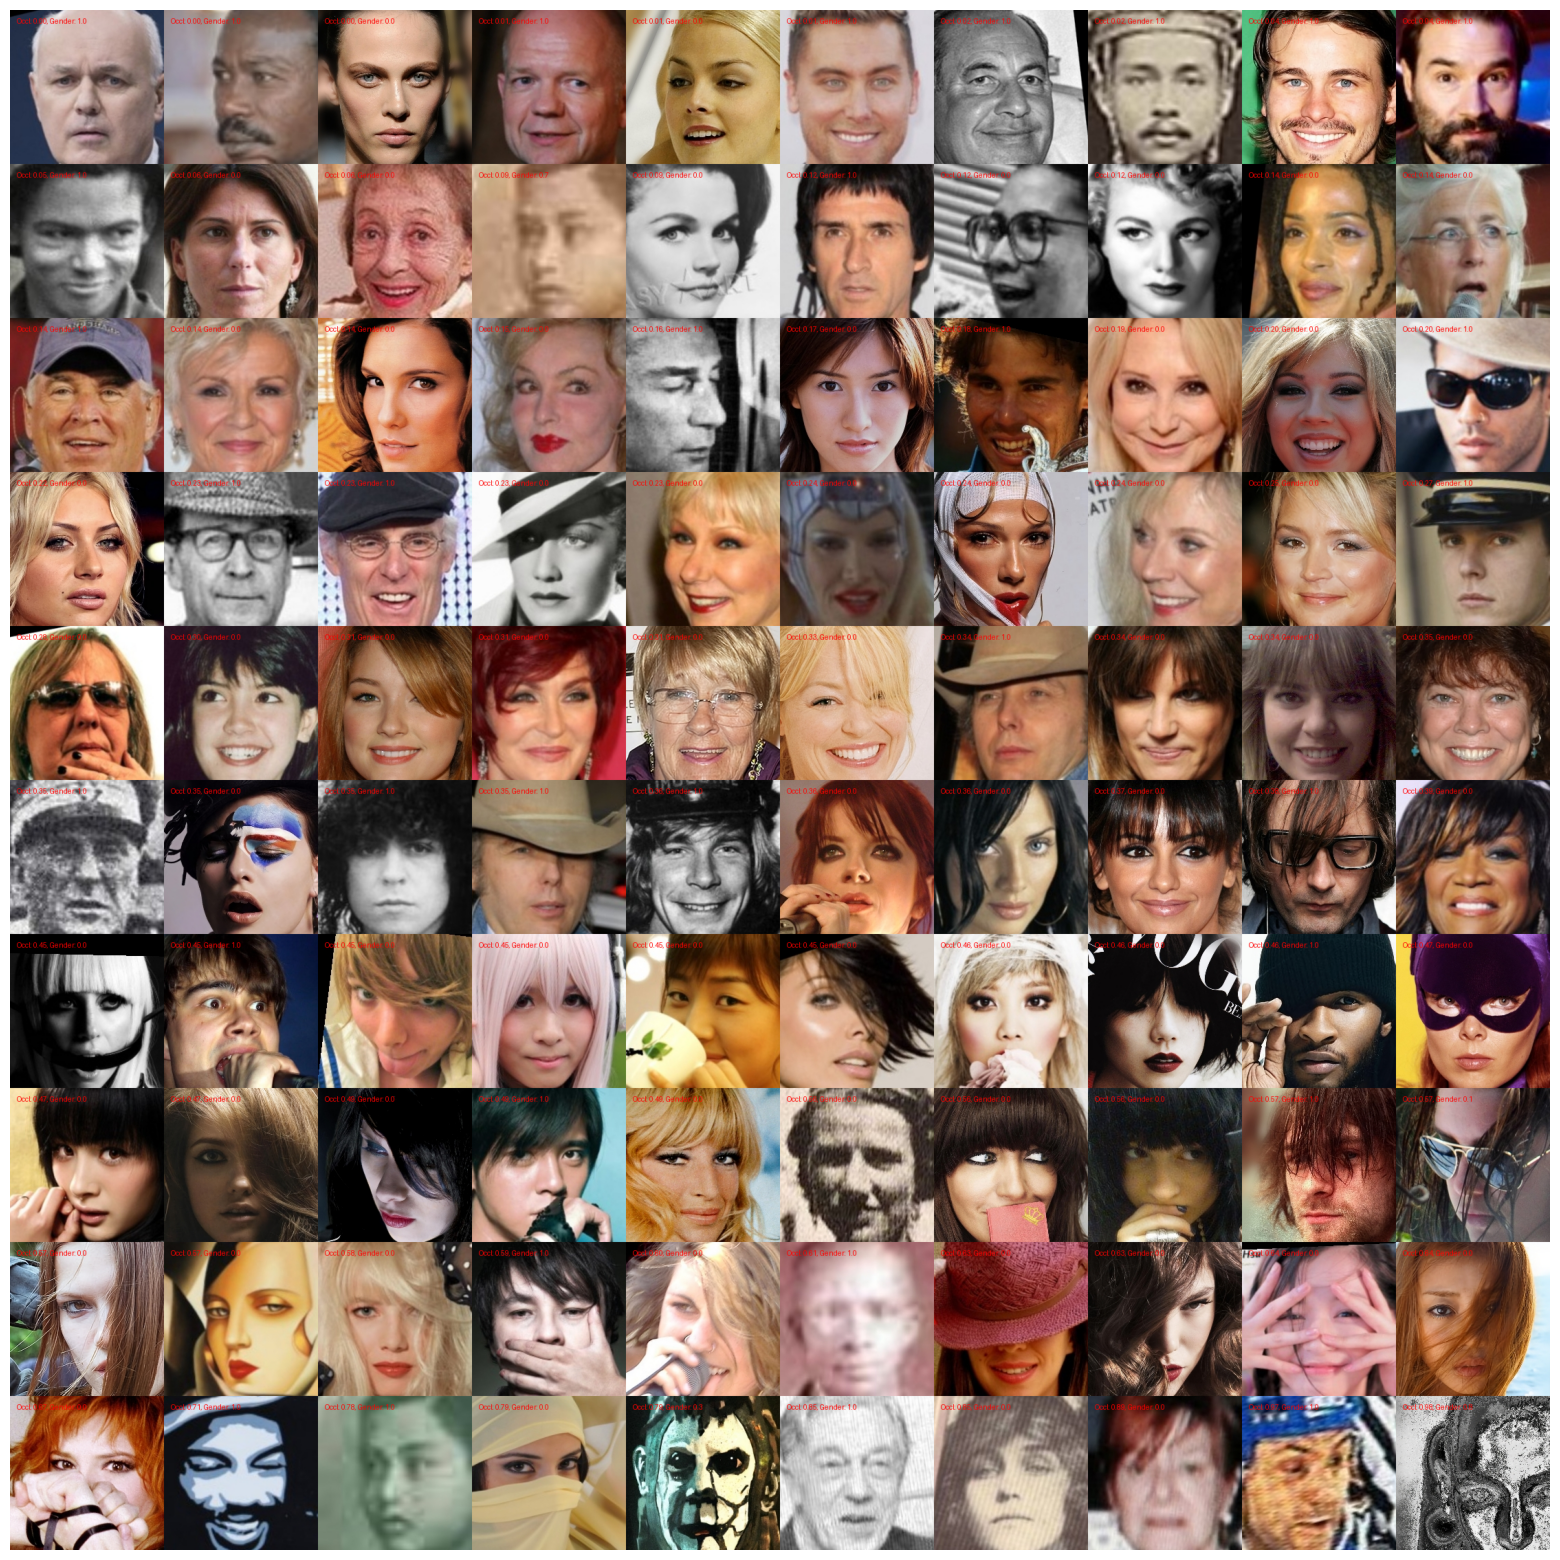

In [ ]:
def create_panel(df, image_dir, occlusion_start, occlusion_end, num_samples=10, panel_size=10):
    """_summary_

    Args: 
        df: DataFrame containing the data
        image_dir: Directory containing the images
        occlusion_start: Start of the occlusion range
        occlusion_end: End of the occlusion range
        num_samples: Number of samples to take from each occlusion range
        panel_size: Number of images to display in each row/column of the panel

    Returns:
        panel: Image containing the sampled images
    """
    filtered_df = df[(df['FaceOcclusion'] >= occlusion_start) & (df['FaceOcclusion'] <= occlusion_end)]

    sampled_images = []
    for occlusion in np.linspace(occlusion_start, occlusion_end, num=panel_size):
        occlusion_range_df = filtered_df[(filtered_df['FaceOcclusion'] >= occlusion) & (df['FaceOcclusion'] < occlusion + (occlusion_end - occlusion_start) / panel_size)]
        if len(occlusion_range_df) > num_samples:
            sampled_df = occlusion_range_df.sample(n=num_samples, random_state=42)
        else:
            sampled_df = occlusion_range_df
        for _, row in sampled_df.iterrows():
            image_path = os.path.join(image_dir, row['filename'])
            image = Image.open(image_path).convert('RGB')
            sampled_images.append((image, row['FaceOcclusion'], row['gender']))

    # Sort the images by their occlusion rate
    sampled_images.sort(key=lambda x: x[1])

    panel = Image.new('RGB', (224 * panel_size, 224 * panel_size))

    font = ImageFont.load_default()

    for i, (image, occlusion, gender) in enumerate(sampled_images):
        # Determine the position to paste the image
        x = (i % panel_size) * 224
        y = (i // panel_size) * 224

        # Draw occlusion rate and gender on the image
        draw = ImageDraw.Draw(image)
        text = f"Occl: {occlusion:.2f}, Gender: {gender:.1f}"
        draw.text((10, 10), text, font=font, fill=(255, 0, 0))

        # Paste the image onto the panel
        panel.paste(image, (x, y))

    return panel

occlusion_start = 0
occlusion_end = 1.0
num_samples = 15
panel_size = 10

panel = create_panel(df_train, image_dir, occlusion_start, occlusion_end, num_samples, panel_size)

# Display the panel
plt.figure(figsize=(20, 20))
plt.imshow(panel)
plt.axis('off')
plt.show()

## 3.4. Data Augmentation

### 3.4.1. Augmentation par VAE

Nous allons procéder avec 3 étapes de data augmentation.
1. Data augmentation par VAE
2. Application d'effet mirroir sur les images originaux
3. Equilibrage de classes par oversampling sur les images générés par le VAE

#### 3.4.1.1. Data Preparation avec effet mirroir

In [10]:
class DatasetWithMirror(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir, transform=None):
        'Initialization'
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.mirror_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.0)
        ])
         
    def __len__(self):
        'Denotes the total number of samples'
        return 2 * len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        if index < len(self.df):
            row = self.df.loc[index]
            img_type = 'original'
        else:
            row = self.df.loc[index - len(self.df)]
            img_type = 'mirror'

        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}").convert('L')
        y = row['FaceOcclusion']
        gender = row['gender']

        if img_type == 'original':
            if self.transform:
                img = self.transform(img)
        else:
            img = self.mirror_transform(img)
            if self.transform:
                img = self.transform(img)
        
        y = np.float32(y)
        cond = torch.tensor([y, gender], dtype=torch.float32)

        return img, cond

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

training_set = DatasetWithMirror(df_train, image_dir, transform)
validation_set = DatasetWithMirror(df_val, image_dir, transform)

params_train = {'batch_size': 8,
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': 8,
              'shuffle': False,
              'num_workers': 0}

training_generator = DataLoader(training_set, **params_train)
validation_generator = DataLoader(validation_set, **params_val)

#### 3.4.1.2. VAE Architecture

In [12]:
class Encoder(nn.Module):
    'Encoder for the VAE model'
    def __init__(self, img_shape, latent_dim, condition_dim):
        'Initialization'
        super(Encoder, self).__init__()
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        num_input_features = int(np.prod(img_shape)) + condition_dim
        self.fc1 = nn.Linear(num_input_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, img, cond):
        'Forward pass'
        x = torch.cat((img.view(img.size(0), -1), cond), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    'Decoder for the VAE model'
    def __init__(self, img_shape, latent_dim, condition_dim):
        'Initialization'
        super(Decoder, self).__init__()
        self.img_shape = img_shape
        num_input_features = latent_dim + condition_dim
        self.fc1 = nn.Linear(num_input_features, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, int(np.prod(img_shape)))

    def forward(self, z, cond):
        'Forward pass'
        x = torch.cat((z, cond), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        img = torch.sigmoid(self.fc3(x))
        img = img.view(img.size(0), *self.img_shape)
        return img


class VAE(nn.Module):
    'Variational Autoencoder model'
    def __init__(self, img_shape, latent_dim, condition_dim):
        'Initialization'
        super(VAE, self).__init__()
        self.encoder = Encoder(img_shape, latent_dim, condition_dim)
        self.decoder = Decoder(img_shape, latent_dim, condition_dim)

    def reparameterize(self, mu, logvar):
        'Reparameterization trick to sample from N(mu, var) distribution'
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img, cond):
        'Forward pass'
        mu, logvar = self.encoder(img, cond)
        z = self.reparameterize(mu, logvar)
        reconstructed_img = self.decoder(z, cond)
        return reconstructed_img, mu, logvar

#### 3.4.1.3. VAE Loss Function

In [13]:
def vae_loss(reconstructed_img, img, mu, logvar):
    """_summary_

    Args:
        reconstructed_img: Reconstructed image
        img: Original image
        mu: Mean of the latent distribution
        logvar: Log variance of the latent distribution

    Returns:
        loss: Total loss
    """
    recon_loss = F.mse_loss(reconstructed_img, img, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

#### 3.4.1.4. VAE Training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
latent_dim = 100
condition_dim = 2
learning_rate = 0.001
num_epochs = 20
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
img_shape = (1, 224, 224)

vae = VAE(img_shape, latent_dim, condition_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered")
        break
    
    vae.train()
    train_loss = 0
    with tqdm(total=len(training_generator), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for img, cond in training_generator:
            img = img.to(device)
            cond = cond.to(device)

            optimizer.zero_grad()
            reconstructed_img, mu, logvar = vae(img, cond)
            loss = vae_loss(reconstructed_img, img, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            pbar.set_postfix({"Loss": loss.item()})
            pbar.update(1)

    train_loss /= len(training_generator.dataset)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")

    # Validation
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for img, cond in validation_generator:
            img = img.to(device)
            cond = cond.to(device)
            reconstructed_img, mu, logvar = vae(img, cond)
            loss = vae_loss(reconstructed_img, img, mu, logvar)
            val_loss += loss.item()
    val_loss /= len(validation_generator.dataset)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0.0
        torch.save(vae.state_dict(), "vae_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

#### 3.4.1.5. Verification de l'entrainement du modele VAE
Un echantillonage equilibre sur les tranches de face occlusion et gender est effectue afin de verifier que le modele a bien appris les caraterisitques des visages avec differents degres de face occlusion et gender.

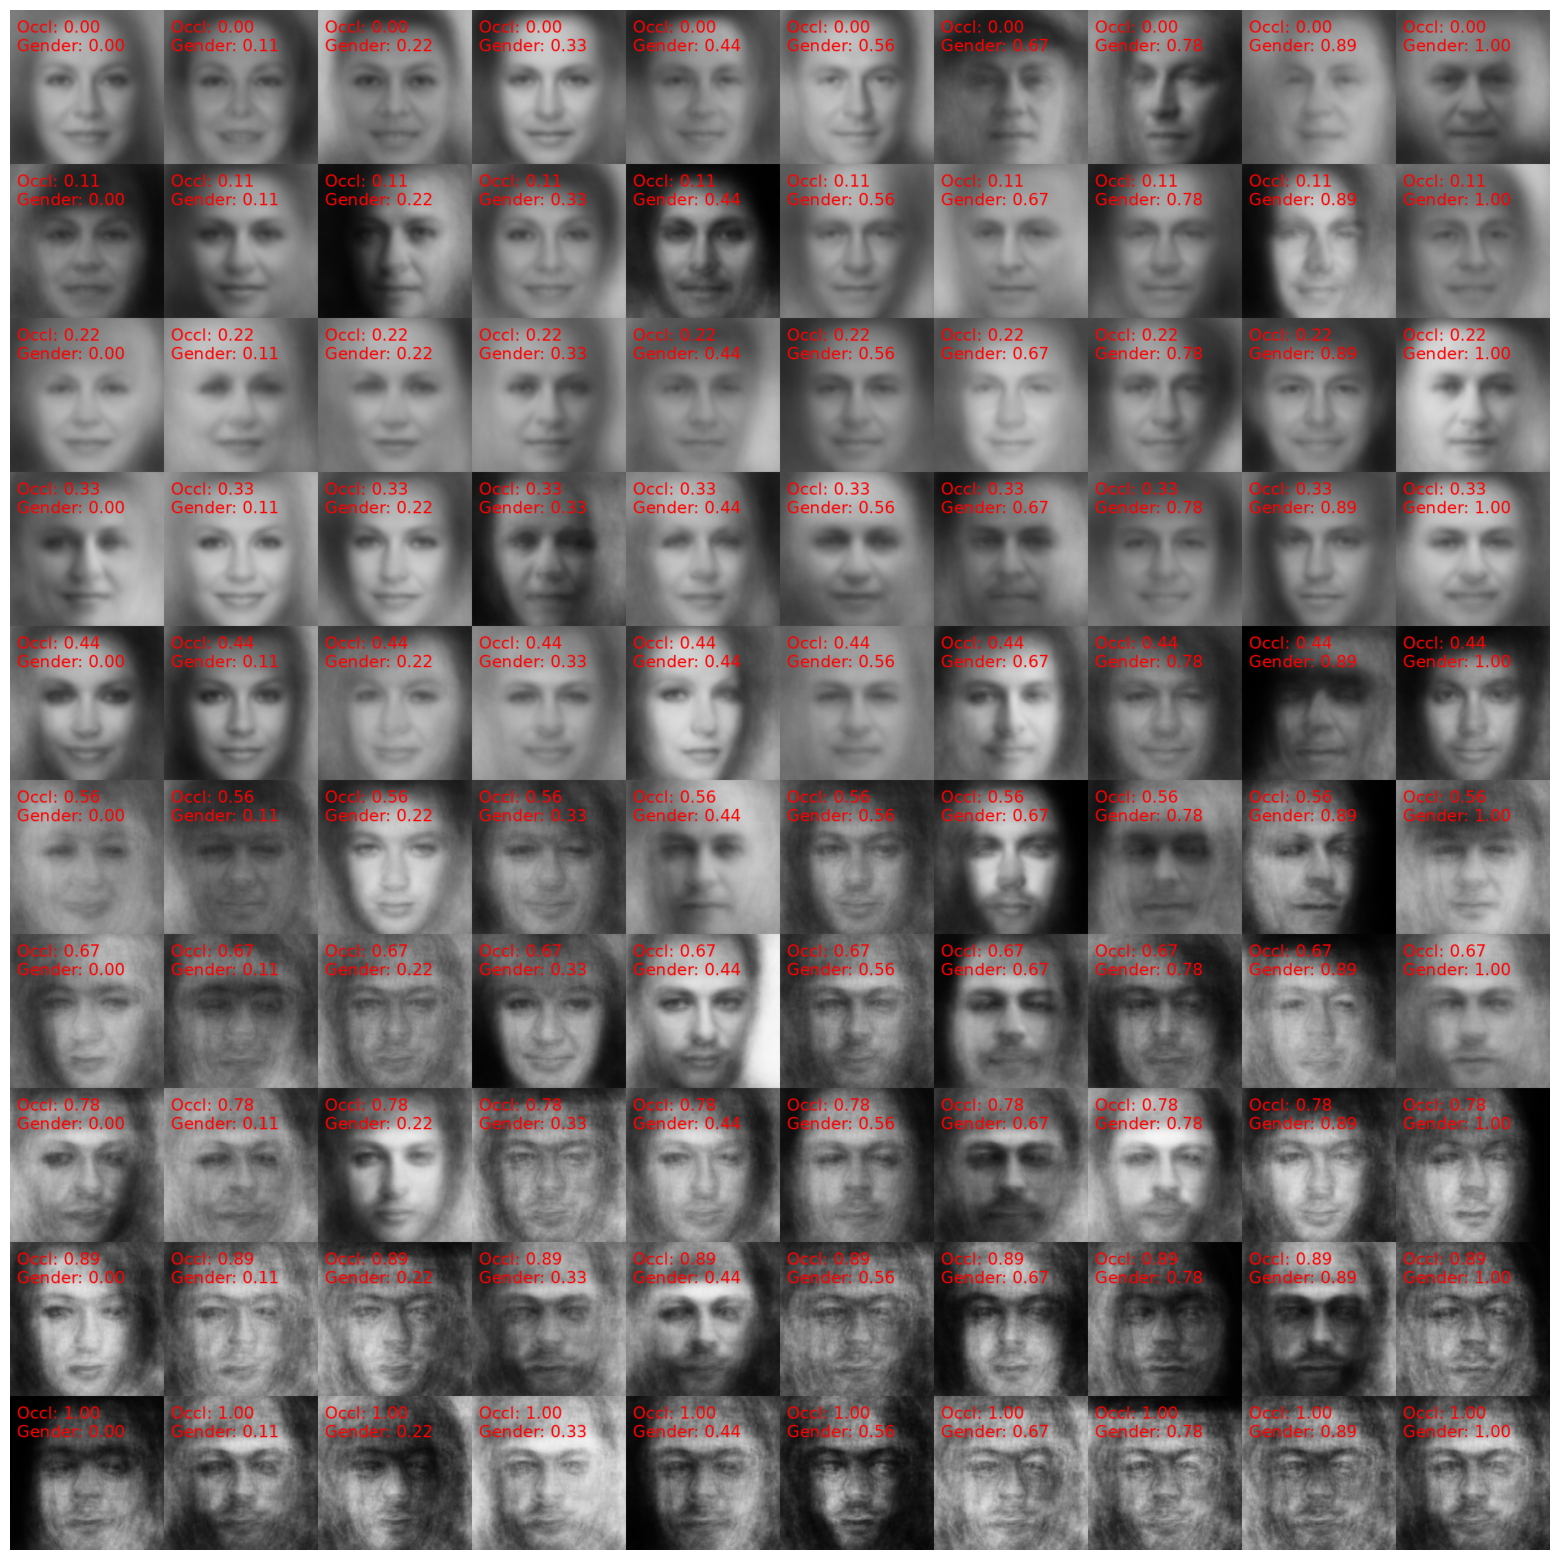

In [ ]:
latent_dim = 100
condition_dim = 2
img_shape = (1, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(img_shape, latent_dim, condition_dim).to(device)

vae.load_state_dict(torch.load("vae_best.pth"))
vae.eval()

def sample_images(vae, num_samples, condition):
    """_summary_

    Args:
        vae: VAE model
        num_samples: Number of samples to generate
        condition: Condition vector

    Returns:
        sampled_images: Sampled images
    """
    z = torch.randn(num_samples, latent_dim).to(device).float()
    condition = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)
    with torch.no_grad():
        sampled_images = vae.decoder(z, condition)
    return sampled_images

def create_panel(vae, img_shape, num_samples=10):
    """_summary_

    Args:
        vae: VAE model
        img_shape: Shape of the images
        num_samples: Number of samples to generate

    Returns:
        panel: Image containing the sampled images
    """
    panel_images = []

    # Varying occlusion rate and gender from 0 to 1
    for occlusion_rate in np.linspace(0, 1, num_samples):
        row_images = []
        for gender in np.linspace(0, 1, num_samples):
            condition = [occlusion_rate, gender]
            sampled_image = sample_images(vae, 1, condition).cpu().numpy()[0]
            row_images.append((sampled_image, occlusion_rate, gender))
        panel_images.append(row_images)

    # Create a collage of images
    panel = Image.new('RGB', (img_shape[2] * num_samples, img_shape[1] * num_samples))

    font_path = fm.findfont(fm.FontProperties(family='DejaVu Sans'))
    font = ImageFont.truetype(font_path, 24)  # You can adjust the font size here

    for i, row in enumerate(panel_images):
        for j, (sampled_image, occlusion_rate, gender) in enumerate(row):
            img_pil = Image.fromarray((sampled_image[0] * 255).astype(np.uint8)).convert("RGB")
            draw = ImageDraw.Draw(img_pil)
            text = f"Occl: {occlusion_rate:.2f}\nGender: {gender:.2f}"
            draw.text((10, 10), text, font=font, fill=(255, 0, 0))  # Red color
            panel.paste(img_pil, (j * img_shape[2], i * img_shape[1]))

    return panel

# Create a panel of 10x10 images
num_samples = 10
panel = create_panel(vae, img_shape, num_samples=num_samples)
plt.figure(figsize=(20, 20))
plt.imshow(panel)
plt.axis('off')
plt.show()
panel.save("vae_sample_panel.png")

Le VAE semble avoir bien appris les caracteristiques de face occlusion et gender, representes dans les images echantillones de l'espace latent.

#### 3.4.1.6. Generer les images a partir de VAE pour la data augmentation

In [15]:
# Assuming the VAE model is already defined and trained as `vae`
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.load_state_dict(torch.load("vae_best.pth"))
vae.eval()

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=50178, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=100, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=102, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=50176, bias=True)
  )
)

In [16]:
# Helper function to generate images
def sample_images(vae, num_samples, condition):
    """_summary_

    Args:
        vae: VAE model
        num_samples: Number of samples to generate
        condition: Condition vector

    Returns:
        sampled_images: Sampled images
    """
    z = torch.randn(num_samples, latent_dim).to(device).float()
    condition = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)
    with torch.no_grad():
        sampled_images = vae.decoder(z, condition)
    return sampled_images.cpu().numpy()

In [17]:
# Identify underrepresented occlusion and gender values
def get_underrepresented_values(df, num_bins=10):
    """_summary_

    Args:
        df: DataFrame containing the data
        num_bins: Number of bins to use for histogram

    Returns:
        underrepresented_occlusions: Underrepresented occlusion values
        underrepresented_gender: Underrepresented gender values
    """
    occlusion_counts, occlusion_bins = np.histogram(df['FaceOcclusion'], bins=num_bins)
    gender_counts, gender_bins = np.histogram(df['gender'], bins=num_bins)
    
    underrepresented_occlusions = occlusion_bins[:-1][occlusion_counts < np.mean(occlusion_counts)]
    underrepresented_genders = gender_bins[:-1][gender_counts < np.mean(gender_counts)]
    
    return underrepresented_occlusions, underrepresented_genders

underrepresented_occlusions, underrepresented_genders = get_underrepresented_values(df_train)
underrepresented_occlusions, underrepresented_genders

(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))

In [18]:
# Generate additional images
generated_images = []
generated_labels = []

for occlusion in underrepresented_occlusions:
    for gender in underrepresented_genders:
        condition = [occlusion, gender]
        samples = sample_images(vae, 100, condition)
        for img in samples:
            generated_images.append(img)
            generated_labels.append([occlusion, gender])

# Convert generated images and labels to dataframe
generated_df = pd.DataFrame(generated_labels, columns=['FaceOcclusion', 'gender'])
generated_df['filename'] = [f"generated_{i}.png" for i in range(len(generated_df))]
display(len(generated_labels), len(generated_df))

output_dir = "./crops_100K/generated_images"
! rm -rf ./crops_100K/generated_images
! mkdir ./crops_100K/generated_images
for idx, img in tqdm(enumerate(generated_images), total=len(generated_images), desc="Saving images"):
    img_pil = Image.fromarray((img[0] * 255).astype(np.uint8)).convert("RGB")
    img_pil.save(f"{output_dir}/generated_{idx}.png")

6400

6400

In [19]:
# Update the file paths in the dataframe
generated_df['filename'] = generated_df['filename'].apply(lambda x: f"generated_images/{x}")

# Merge original and generated dataframes
df_combined = pd.concat([df_train, generated_df], ignore_index=True)
display(generated_df.shape, df_combined.shape)
display(df_combined)

(6400, 3)

(87741, 4)

index                             filename  FaceOcclusion  gender
0      20000.0            database1/img00013741.jpg          0.275   0.997
1      20001.0            database1/img00006703.jpg          0.041   0.998
2      20002.0            database1/img00004500.jpg          0.013   0.997
3      20003.0            database1/img00021309.jpg          0.192   0.001
4      20004.0            database1/img00007281.jpg          0.183   0.999
...        ...                                  ...            ...     ...
87736      NaN  generated_images/generated_6395.png          0.900   0.800
87737      NaN  generated_images/generated_6396.png          0.900   0.800
87738      NaN  generated_images/generated_6397.png          0.900   0.800
87739      NaN  generated_images/generated_6398.png          0.900   0.800
87740      NaN  generated_images/generated_6399.png          0.900   0.800

[87741 rows x 4 columns]

### 3.4.2. Rééquilibrage des classes APRES data augmentation par VAE

In [20]:
df_combined['new_gender'] = df_combined['gender'].apply(lambda x: 1 if x > 0.5 else 0)
df_train_genre0 = df_combined.loc[df_combined['new_gender'] == 0]
df_train_genre1 = df_combined.loc[df_combined['new_gender'] == 1]

print(df_train_genre0.shape)
print(df_train_genre1.shape)

(31702, 5)
(56039, 5)


/tmp/ipykernel_16855/731930031.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis', legend=False)


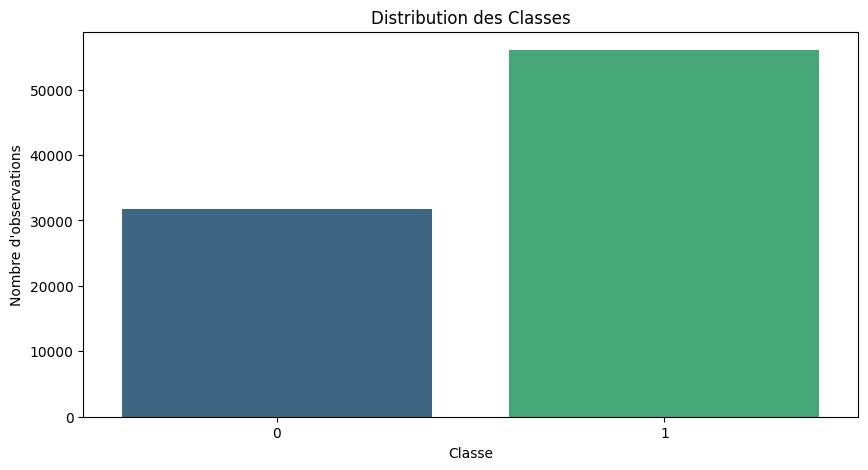

In [24]:
labels, counts = np.unique(df_combined['new_gender'], return_counts=True)

df_labels = pd.DataFrame({'Label': labels, 'Count': counts})

plt.figure(figsize=(10, 5))
sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis', legend=False)
plt.title('Distribution des Classes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

**On remarque un déséquilibre dans le nombre d'images entre nos 2 genres.**

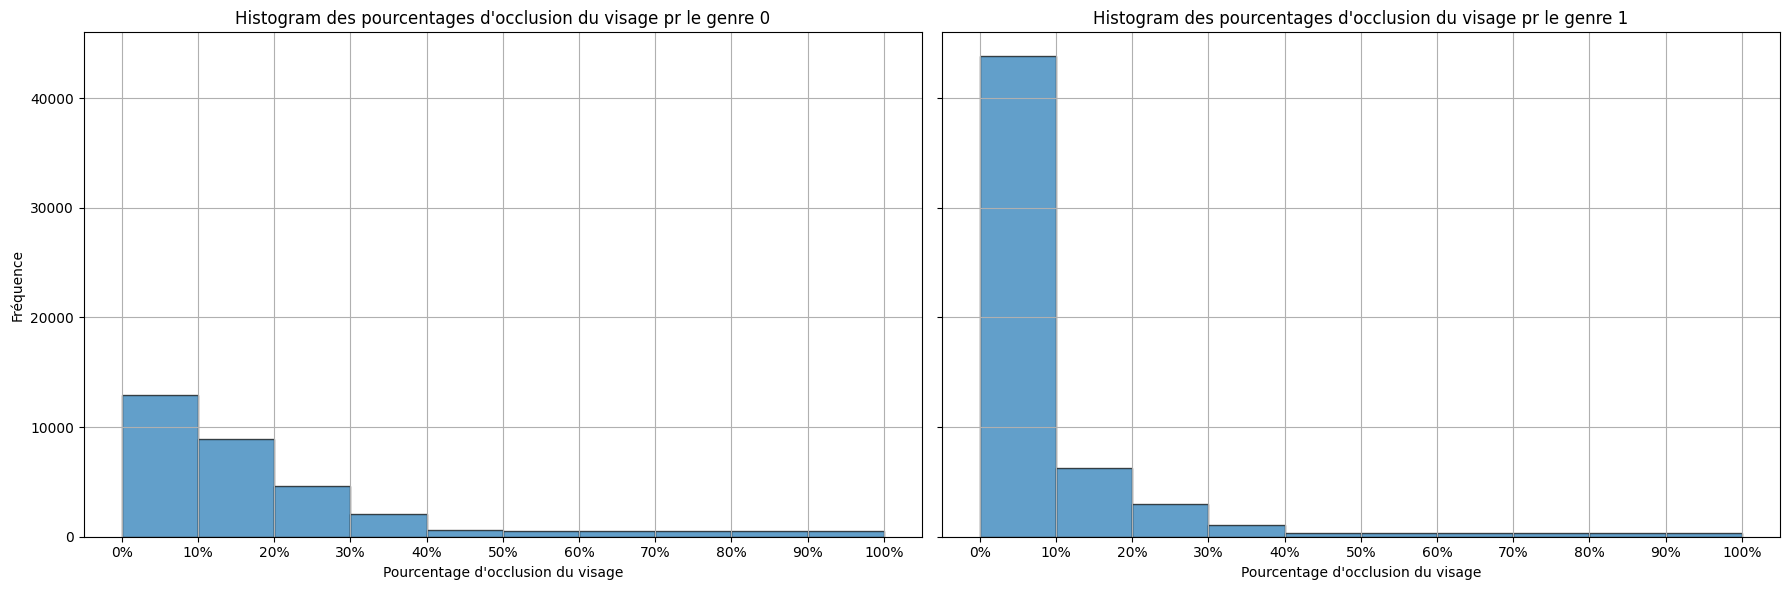

In [17]:
bins = [i/10 for i in range(0, 11)]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# gender 0
axes[0].hist(df_train_genre0['FaceOcclusion'], bins=bins, edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram des pourcentages d\'occlusion du visage pr le genre 0')
axes[0].set_xlabel('Pourcentage d\'occlusion du visage')
axes[0].set_ylabel('Fréquence')
axes[0].set_xticks(bins)
axes[0].set_xticklabels([f'{int(b*100)}%' for b in bins])
axes[0].grid(True)

# gender 1
axes[1].hist(df_train_genre1['FaceOcclusion'], bins=bins, edgecolor='black', alpha=0.7)
axes[1].set_title('Histogram des pourcentages d\'occlusion du visage pr le genre 1')
axes[1].set_xlabel('Pourcentage d\'occlusion du visage')
axes[1].set_xticks(bins)
axes[1].set_xticklabels([f'{int(b*100)}%' for b in bins])
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### **On remarque une différence notable sur la répartition des classes entre les genres. Notament un sur représentation des occlusions de 0 à 10% pour le genre 1**

/tmp/ipykernel_159/3930793480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_genre0['OcclusionCategory'] = pd.cut(df_train_genre0['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_159/3930793480.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_genre1['OcclusionCategory'] = pd.cut(df_train_genre1['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)


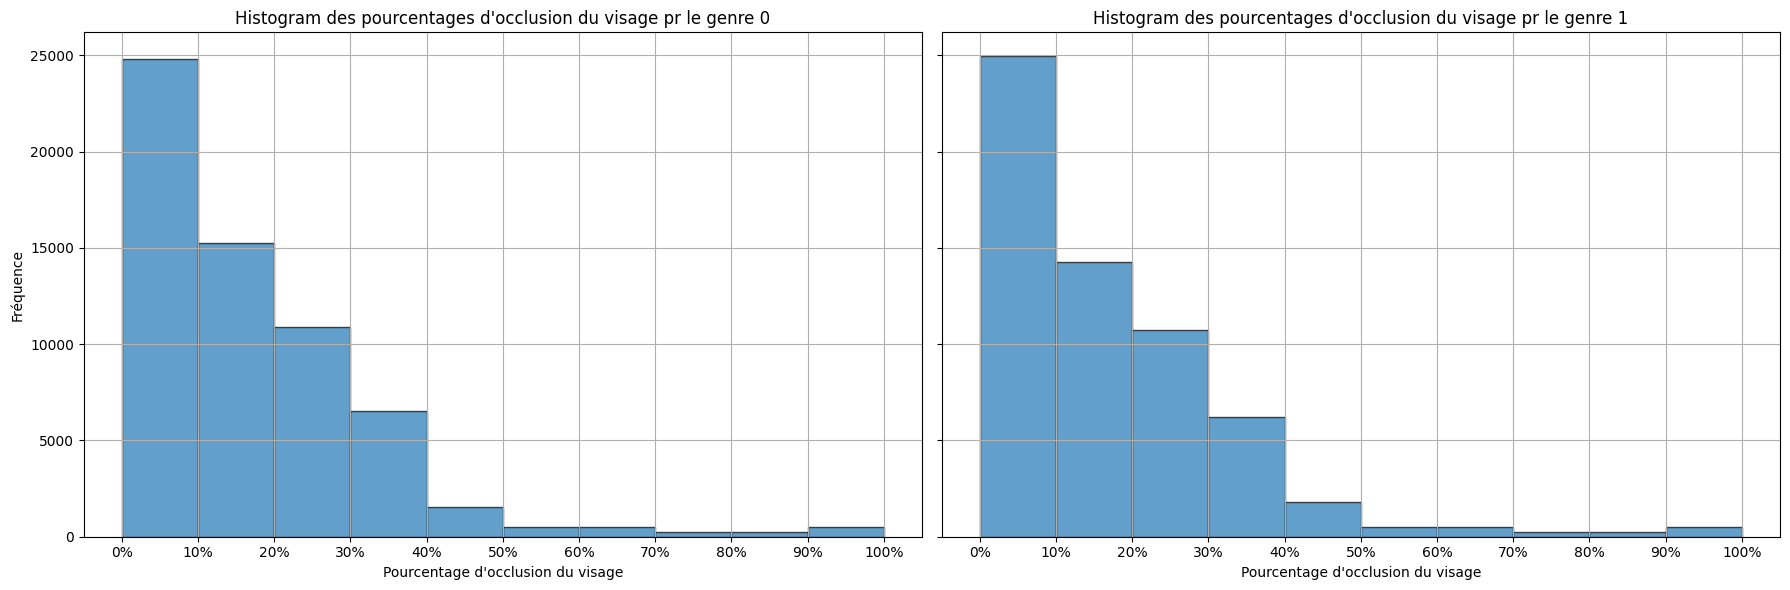

In [18]:
# Balance en pourcentage pour le genre 0
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['Occlusion 0-10', 'Occlusion 10-20', 'Occlusion 20-30', 'Occlusion 30-40', 'Occlusion 40-50', \
          'Occlusion 50-60', 'Occlusion 60-70', 'Occlusion 70-80', 'Occlusion 80-90', 'Occlusion 90-100']

df_train_genre0['OcclusionCategory'] = pd.cut(df_train_genre0['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)

occlusion_categories = {
    'Occlusion 0-10': 25000,
    'Occlusion 10-20': 16000,
    'Occlusion 20-30': 10000,
    'Occlusion 30-40': 8000,
    # 'Occlusion 40-50': 5000,
    'Occlusion 50-60': 500,
    'Occlusion 60-70': 500,
    'Occlusion 70-80': 500,
    'Occlusion 80-90': 500,
    # 'Occlusion 90-100': 1000
}

sampled_dfs = []

for category, sample_size in occlusion_categories.items():
    category_df = df_train_genre0[df_train_genre0['OcclusionCategory'] == category]
    if not category_df.empty:
        sampled_df = category_df.sample(n=sample_size, random_state=42, replace=True)
        sampled_dfs.append(sampled_df)

balanced_df_genre0 = pd.concat(sampled_dfs)

balanced_df_genre0 = balanced_df_genre0.sample(frac=1, random_state=42).reset_index(drop=True)

# Balance en pourcentage pour le genre 1
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['Occlusion 0-10', 'Occlusion 10-20', 'Occlusion 20-30', 'Occlusion 30-40', 'Occlusion 40-50', \
          'Occlusion 50-60', 'Occlusion 60-70', 'Occlusion 70-80', 'Occlusion 80-90', 'Occlusion 90-100']

df_train_genre1['OcclusionCategory'] = pd.cut(df_train_genre1['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)

# On sous-échantillonne la classe beaucoup trop représentée (0-10% d'occlusion)
occ0_10 = df_train_genre1[df_train_genre1['OcclusionCategory'] == 'Occlusion 0-10']
occ0_10_sampled = occ0_10.sample(n=25000, random_state=42)

occlusion_categories = {
    'Occlusion 10-20': 15000,
    'Occlusion 20-30': 10000,
    'Occlusion 30-40': 8000,
    # 'Occlusion 40-50': 5000,
    'Occlusion 50-60': 500,
    'Occlusion 60-70': 500,
    'Occlusion 70-80': 500,
    'Occlusion 80-90': 500,
    # 'Occlusion 90-100': 1000
}

sampled_dfs = []
sampled_dfs.append(occ0_10_sampled)

for category, sample_size in occlusion_categories.items():
    category_df = df_train_genre1[df_train_genre1['OcclusionCategory'] == category]
    if not category_df.empty:
        sampled_df = category_df.sample(n=sample_size, random_state=42, replace=True)
        sampled_dfs.append(sampled_df)

balanced_df_genre1 = pd.concat(sampled_dfs)

balanced_df_genre1 = balanced_df_genre1.sample(frac=1, random_state=42).reset_index(drop=True)

sep = [i/10 for i in range(0, 11)]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# gender 0
axes[0].hist(balanced_df_genre0['FaceOcclusion'], bins=sep, edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram des pourcentages d\'occlusion du visage pr le genre 0')
axes[0].set_xlabel('Pourcentage d\'occlusion du visage')
axes[0].set_ylabel('Fréquence')
axes[0].set_xticks(sep)
axes[0].set_xticklabels([f'{int(b*100)}%' for b in sep])
axes[0].grid(True)

# gender 1
axes[1].hist(balanced_df_genre1['FaceOcclusion'], bins=sep, edgecolor='black', alpha=0.7)
axes[1].set_title('Histogram des pourcentages d\'occlusion du visage pr le genre 1')
axes[1].set_xlabel('Pourcentage d\'occlusion du visage')
axes[1].set_xticks(sep)
axes[1].set_xticklabels([f'{int(b*100)}%' for b in sep])
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### **On remarque que l'augmentation de données nous a bien permis d'avoir une répartition plus équitable des classes entre nos genres**

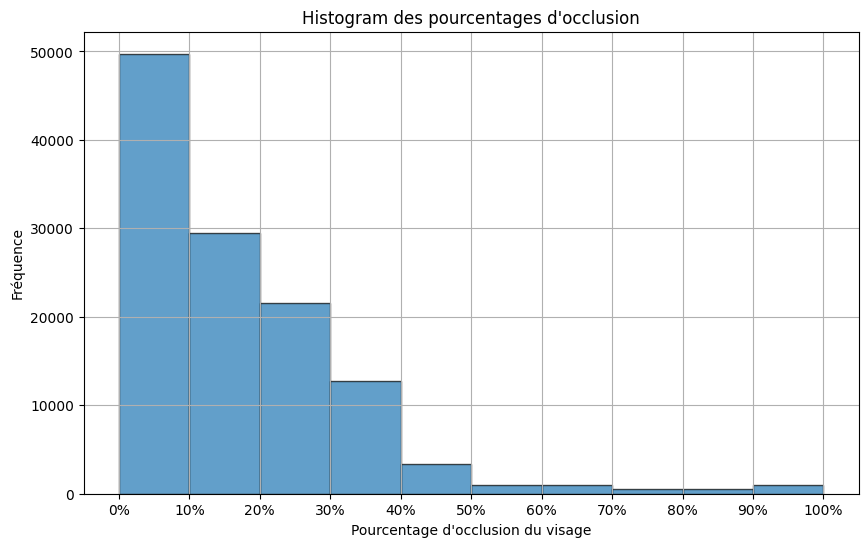

In [19]:
df_train_balanced_percentages = pd.concat([balanced_df_genre0, balanced_df_genre1])
df_train_balanced_percentages = df_train_balanced_percentages.sample(frac=1, random_state=42).reset_index(drop=True)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_train_balanced_percentages['FaceOcclusion'], bins=sep, edgecolor='black', alpha=0.7)
plt.title('Histogram des pourcentages d\'occlusion')
plt.xlabel('Pourcentage d\'occlusion du visage')
plt.ylabel('Fréquence')
plt.xticks(sep, [f'{int(b*100)}%' for b in sep]) 
plt.grid(True)
plt.show()

/tmp/ipykernel_159/3481947438.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis', legend=False)


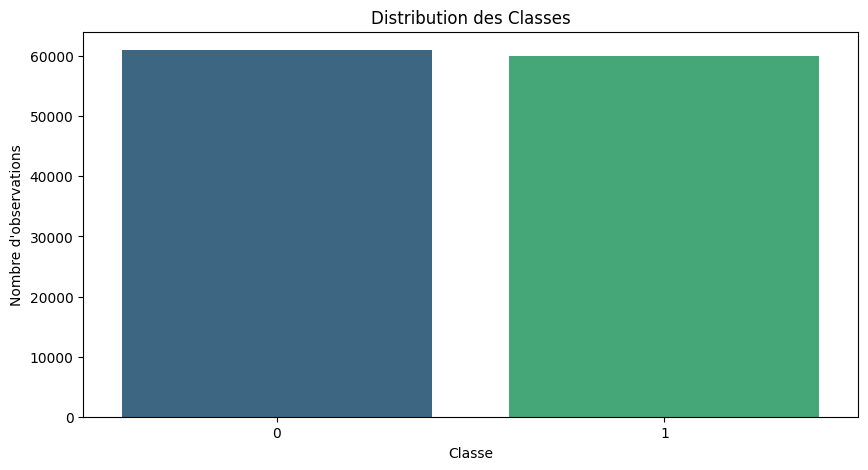

In [20]:
labels, counts = np.unique(df_train_balanced_percentages['new_gender'], return_counts=True)

df_labels = pd.DataFrame({'Label': labels, 'Count': counts})

plt.figure(figsize=(10, 5))
sns.barplot(x='Label', y='Count', data=df_labels, palette='viridis', legend=False)
plt.title('Distribution des Classes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.show()

#### **On remarque aussi que nous avons aussi équiibré entre le nombre de données par genre.**

### 3.4.3. Application d'effet mirroir sur les images équilibrés

#### **Ici nous décidons de faire de la data augmentation en appliquant à nos images de base un effet miroir. On peut donc doubler notre nombre d'images.**

In [39]:
class DatasetWithMirror(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
        'Initialization'
        self.image_dir = image_dir
        self.df = df
        self.transform = transforms.ToTensor()
        self.mirror_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=1.0)  # Toujours appliquer l'effet miroir
        ])
         
    def __len__(self):
        'Denotes the total number of samples'
        return 2 * len(self.df)  # Double la taille pour inclure les images miroir

    def __getitem__(self, index):
        'Generates one sample of data'
        if index < len(self.df):
            row = self.df.loc[index]
            img_type = 'original'
        else:
            row = self.df.loc[index - len(self.df)]
            img_type = 'mirror'

        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        if img_type == 'original':
            X = self.transform(img)  # Image originale
        else:
            X = self.mirror_transform(img)  # Image avec effet miroir
        
        y = np.float32(y)

        return X, y, gender, filename

# Initialisation des jeux de données
training_set = DatasetWithMirror(df_train_balanced_percentages, image_dir)
validation_set = DatasetWithMirror(df_val, image_dir)

# Paramètres pour les DataLoader
params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

# Création des DataLoader
training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

### 4. Entraînement des modèles

Nous avons testé de finetuner différents modèles pré-entraînes pour la tâche de prédiction du taux d'occlusion de visage.
 - efficientnet-b0
 - efficientnet-b7
 - resnet50
 - mobilenet_v3_small
 - DenseNet
 - VGG

#### 4.1. Load modele pré-entraîné

In [40]:
# Mobilenet
# model = torchvision.models.mobilenet_v3_small(num_classes=1)

# EfficientNet
!pip install torch torchvision efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b5')
#model = models.resnet50(pretrained=True)
#model = models.vgg16(pretrained=True)
#model = EfficientNet.from_pretrained('efficientnet-b0')
#model = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

# DenseNet
# class DenseNetOcclusionRegressor(nn.Module):
#     def __init__(self):
#         super(DenseNetOcclusionRegressor, self).__init__()
#         self.model = models.densenet121(pretrained=True) 
#         num_ftrs = self.model.classifier.in_features
#         self.model.classifier = nn.Linear(num_ftrs, 1)  

#     def forward(self, x):
#         x = self.model(x)
#         return x

# model = DenseNetOcclusionRegressor()

if torch.cuda.is_available():
    model.cuda()    
# model

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=209fdda0ab8b3c236a004f18372261898a90021f8e129dfd4970f40cb3810f5b
  Stored in directory: /home/onyxia/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/onyxia/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:01<00:00, 108MB/s]  


Loaded pretrained weights for efficientnet-b5


#### 4.2. Loss and optimizer

In [41]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

#### 4.3. Train Modèle

In [42]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [44]:
num_epochs = 14
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
val_loss_rslts = []

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping")
        break
    
    print(f"Epoch {epoch}")
    model.train()
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (X_val, y_val, _, _) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val = torch.reshape(y_val, (len(y_val), 1))
            y_val_pred = model(X_val)
            val_loss += loss_fn(y_val_pred, y_val).item()
    
    val_loss /= len(validation_generator)
    val_loss_rslts.append(val_loss)
    print(f'Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epochs_no_improve} epochs with no improvement.')
            early_stop = True
            
for param_group in optimizer.param_groups:
    current_learning_rate = param_group['lr']
    print(f'Valeur finale du learning rate : {current_learning_rate}')

Epoch 0


  0%|          | 0/31250 [00:00<?, ?it/s]

tensor(0.1326, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [01:13<2:32:18,  3.40it/s]

tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [02:23<3:36:57,  2.37it/s]

tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [03:39<3:11:11,  2.67it/s]

tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [04:46<2:22:41,  3.56it/s] 

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [05:59<2:56:13,  2.86it/s]

tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [07:08<2:41:57,  3.09it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [08:12<2:43:13,  3.05it/s]

tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [09:17<2:34:36,  3.20it/s]

tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [10:18<2:51:44,  2.86it/s]

tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [11:29<3:21:47,  2.42it/s]

tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [12:40<2:21:43,  3.42it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [13:44<2:26:59,  3.27it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [14:47<2:23:14,  3.33it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [15:49<2:10:02,  3.65it/s]

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [16:48<5:40:36,  1.38it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [18:00<2:06:59,  3.68it/s] 

tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [19:01<2:02:57,  3.77it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [20:00<2:07:52,  3.60it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [20:59<2:14:00,  3.41it/s]

tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [21:54<2:11:12,  3.46it/s]

tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [22:55<2:25:50,  3.09it/s]

tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [23:54<2:15:14,  3.31it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [24:48<1:45:49,  4.20it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [25:43<1:41:30,  4.34it/s]

tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [26:36<2:06:12,  3.47it/s]

tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [27:30<3:29:55,  2.07it/s]

tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [28:29<1:58:53,  3.62it/s]

tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [29:31<1:51:48,  3.82it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [30:33<1:54:24,  3.71it/s] 

tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [31:31<3:40:46,  1.91it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [32:37<1:53:57,  3.66it/s] 

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [33:29<1:43:18,  4.01it/s]

tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [34:23<1:58:55,  3.45it/s]

tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [35:20<1:50:24,  3.69it/s]

tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [36:14<1:40:57,  4.00it/s]

tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [37:07<1:56:31,  3.44it/s]

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [37:57<1:49:05,  3.64it/s]

tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [38:49<2:03:45,  3.18it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [39:43<1:26:26,  4.52it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [40:33<1:49:29,  3.54it/s]

tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [41:28<2:10:54,  2.93it/s]

tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [42:18<1:23:15,  4.57it/s]

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [44:51<1:40:20,  3.70it/s]

tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [45:40<1:22:56,  4.43it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [46:28<1:21:45,  4.45it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [47:19<1:32:22,  3.91it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [48:09<1:28:46,  4.03it/s]

tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [48:57<1:26:52,  4.08it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [49:45<1:18:10,  4.49it/s]

tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [50:37<1:40:10,  3.47it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [51:25<1:20:34,  4.27it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [52:14<1:25:12,  4.00it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [53:07<1:14:59,  4.50it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [53:55<1:12:44,  4.59it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [54:43<1:21:52,  4.04it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [55:28<1:14:29,  4.40it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [56:16<1:11:04,  4.56it/s]

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11905/31250 [56:40<1:14:22,  4.33it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 15%|█▌        | 4801/31250 [17:30<1:34:57,  4.64it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:14<1:34:39,  4.62it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:23<1:33:15,  4.58it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [21:07<1:30:42,  4.68it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:50<1:31:35,  4.59it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:34<1:30:48,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:17<1:30:56,  4.55it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [24:01<1:29:21,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:45<1:28:38,  4.60it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:29<1:28:48,  4.55it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [26:14<1:26:06,  4.66it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [26:59<1:26:27,  4.60it/s]

tensor(8.6551e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:43<1:25:05,  4.63it/s]

tensor(3.4333e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:27<1:25:57,  4.55it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [29:11<1:29:18,  4.34it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:55<1:23:33,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:40<1:23:04,  4.58it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8575/31250 [31:18<1:21:33,  4.63it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

  6%|▋         | 2001/31250 [07:28<1:45:00,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [08:12<1:45:50,  4.57it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:57<1:44:26,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:41<1:47:08,  4.46it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:26<1:42:42,  4.62it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [11:12<1:44:20,  4.51it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:56<1:41:43,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:40<1:40:03,  4.64it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [13:27<1:40:14,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [14:11<1:39:12,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:54<1:41:48,  4.46it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:38<1:38:16,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [16:21<1:37:01,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [17:06<1:35:31,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:49<1:35:38,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:33<1:38:40,  4.43it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [19:17<1:34:17,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [20:01<1:33:33,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:45<1:33:50,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [21:29<1:32:37,  4.58it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [22:13<1:31:33,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:57<1:30:19,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:41<1:29:49,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [24:25<1:32:27,  4.44it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [25:09<1:29:05,  4.57it/s]

tensor(4.6256e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:52<1:28:00,  4.59it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [26:36<1:29:25,  4.48it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [27:20<1:27:02,  4.57it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [28:04<1:24:54,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:47<1:29:23,  4.37it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [29:31<1:24:02,  4.61it/s]

tensor(8.7841e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [30:15<1:24:20,  4.56it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:58<1:21:41,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [31:42<1:23:20,  4.53it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [32:25<1:21:09,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [33:09<1:22:28,  4.50it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:53<1:19:56,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [34:37<1:19:09,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [35:21<1:18:26,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [36:04<1:16:52,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [36:48<1:17:56,  4.54it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [37:32<1:16:29,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [38:16<1:16:43,  4.53it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [39:00<1:15:27,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [39:44<1:13:45,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [40:28<1:13:12,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [41:11<1:13:09,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [41:55<1:11:39,  4.62it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [42:39<1:11:38,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [43:23<1:10:02,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [44:07<1:09:31,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [44:51<1:10:07,  4.53it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [45:35<1:08:20,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [46:19<1:07:18,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [47:03<1:06:18,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [47:48<1:10:07,  4.34it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [48:32<1:05:06,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [49:17<1:24:55,  3.50it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [50:18<1:31:03,  3.23it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [51:23<2:05:32,  2.32it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [52:34<1:41:58,  2.82it/s]

tensor(7.1134e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [53:50<1:50:25,  2.57it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [54:57<1:08:26,  4.10it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [56:07<1:12:46,  3.81it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [57:17<1:15:37,  3.62it/s]

tensor(7.8032e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [58:26<2:10:01,  2.08it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [59:32<1:08:09,  3.92it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [1:00:38<1:33:16,  2.83it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [1:01:55<1:35:57,  2.72it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [1:03:01<1:17:06,  3.34it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [1:04:13<1:58:08,  2.15it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [1:05:34<2:18:09,  1.82it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [1:07:01<1:41:27,  2.44it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [1:08:18<1:26:51,  2.81it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:09:22<1:02:17,  3.87it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:10:41<1:11:16,  3.33it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:11:54<1:32:06,  2.54it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:13:16<1:27:47,  2.63it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:14:37<53:46,  4.23it/s]  

tensor(6.1306e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:16:10<1:27:14,  2.57it/s] 

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:17:27<1:30:23,  2.44it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:18:49<1:54:25,  1.90it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:20:03<1:31:55,  2.33it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:21:11<46:46,  4.51it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:22:08<50:03,  4.15it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:23:00<44:22,  4.60it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:24:10<1:53:01,  1.78it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:25:27<1:02:42,  3.15it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:26:44<53:38,  3.62it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:28:18<1:24:37,  2.25it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:29:35<1:29:36,  2.09it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:30:53<1:41:36,  1.81it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:32:06<57:02,  3.17it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:33:18<1:16:58,  2.31it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:34:29<56:49,  3.06it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:35:43<42:46,  3.99it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:36:54<40:20,  4.15it/s]  

tensor(7.2839e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:38:44<2:46:56,  1.02s/it]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:39:56<42:00,  3.83it/s]  

tensor(7.9335e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:41:12<35:08,  4.48it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:42:20<48:42,  3.16it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:43:26<49:11,  3.07it/s]  

tensor(6.3903e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:44:35<55:21,  2.66it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:45:46<45:50,  3.14it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:47:17<1:33:21,  1.51it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:48:52<53:55,  2.55it/s]  

tensor(8.5198e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:50:02<34:43,  3.86it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:51:17<54:44,  2.39it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:52:35<57:28,  2.22it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:54:34<32:04,  3.87it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:55:45<34:01,  3.55it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:56:55<30:32,  3.85it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:58:31<37:22,  3.05it/s]  

tensor(6.2176e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:59:43<55:30,  2.00it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [2:00:56<25:56,  4.14it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [2:02:04<35:48,  2.91it/s]  

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [2:03:09<24:09,  4.17it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [2:06:06<4:02:44,  2.49s/it]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [2:09:44<30:03,  3.13it/s]  

tensor(7.5808e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [2:10:51<48:58,  1.85it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [2:12:05<23:50,  3.67it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [2:13:15<23:21,  3.60it/s]

tensor(8.6895e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [2:14:34<24:48,  3.26it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [2:15:46<28:13,  2.75it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [2:16:45<16:10,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [2:17:36<15:28,  4.57it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [2:18:22<15:55,  4.24it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [2:19:09<14:08,  4.54it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [2:19:54<14:15,  4.27it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [2:20:39<14:11,  4.05it/s]

tensor(6.8355e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [2:21:24<13:06,  4.13it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [2:22:08<11:01,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [2:22:51<10:20,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [2:23:35<09:36,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [2:24:19<08:52,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [2:25:02<08:09,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [2:25:46<07:23,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [2:26:30<06:46,  4.55it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [2:27:13<05:56,  4.62it/s]

tensor(6.2470e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [2:27:57<05:12,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [2:28:41<04:31,  4.60it/s]

tensor(5.5419e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [2:29:24<04:13,  4.15it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [2:30:08<03:05,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [2:30:52<02:21,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [2:31:35<01:38,  4.54it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [2:32:21<00:54,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [2:33:15<00:27,  1.81it/s]

tensor(8.8832e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [06:13<00:00, 13.37it/s]


Validation Loss: 0.00043703348355577016
Epoch 3


  0%|          | 1/31250 [00:00<1:21:44,  6.37it/s]

tensor(6.1607e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:43<1:53:11,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:39<1:51:41,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:24<1:50:55,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [03:09<1:50:31,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:52<1:49:09,  4.62it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:48<1:47:28,  4.66it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:32<1:49:26,  4.55it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [06:15<1:47:24,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:59<2:02:44,  4.00it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:45<1:45:31,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [08:30<1:45:42,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [09:16<1:44:35,  4.60it/s]

tensor(8.3293e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [10:00<1:43:50,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:44<1:43:18,  4.59it/s]

tensor(8.8688e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [11:27<1:40:46,  4.67it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [12:11<1:41:44,  4.60it/s]

tensor(8.7385e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:54<1:39:58,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [13:38<1:38:45,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [14:22<1:58:08,  3.87it/s]

tensor(6.6620e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [15:06<1:37:51,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:49<1:42:26,  4.40it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [16:33<1:38:23,  4.55it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [17:22<1:35:53,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [18:05<1:35:02,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:48<1:33:38,  4.67it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [19:32<1:32:41,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [20:16<1:32:42,  4.65it/s]

tensor(7.4360e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:59<1:31:59,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [21:44<1:31:58,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [22:54<1:30:10,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [23:37<1:39:44,  4.19it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [24:30<1:30:06,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [25:15<2:16:09,  3.02it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [26:08<1:27:27,  4.66it/s]

tensor(7.5548e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [26:51<1:26:28,  4.67it/s]

tensor(6.8806e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [27:34<1:25:36,  4.68it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [28:17<1:25:01,  4.68it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [29:00<1:25:53,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [29:44<1:26:02,  4.54it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [30:28<1:24:03,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [31:11<1:22:46,  4.64it/s]

tensor(8.9984e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [31:54<1:22:42,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [32:37<1:22:44,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [33:20<1:20:23,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [34:04<1:21:19,  4.56it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [34:47<1:19:05,  4.65it/s]

tensor(7.0635e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [35:30<1:18:58,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [36:14<1:18:37,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [36:57<1:18:16,  4.57it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [37:41<1:15:35,  4.69it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [38:24<1:15:11,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [39:07<1:14:02,  4.69it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [39:50<1:13:48,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [40:33<1:14:07,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [41:17<1:13:45,  4.58it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [42:00<1:11:15,  4.69it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [42:44<1:10:59,  4.66it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [43:27<1:11:25,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [44:10<1:08:40,  4.72it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [44:54<1:09:33,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [45:37<1:08:08,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [46:20<1:08:00,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [47:04<1:06:33,  4.67it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [47:47<1:05:22,  4.70it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [48:30<1:07:23,  4.51it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [49:14<1:04:27,  4.67it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [49:57<1:03:35,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [50:40<1:03:04,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [51:23<1:03:32,  4.58it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [52:07<1:02:00,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [52:50<1:01:29,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [53:33<59:57,  4.68it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [54:17<58:43,  4.72it/s]  

tensor(7.1166e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [55:01<59:05,  4.64it/s]  

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [55:44<1:00:50,  4.45it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [56:27<57:18,  4.67it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [57:10<59:00,  4.48it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [57:54<57:57,  4.50it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [58:37<54:47,  4.70it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [59:20<54:42,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [1:00:04<54:06,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [1:00:46<53:30,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [1:01:30<52:27,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:02:13<52:00,  4.63it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:02:57<52:35,  4.51it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:03:41<51:31,  4.54it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:04:25<50:13,  4.60it/s]

tensor(5.7359e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:05:09<49:44,  4.57it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:05:53<49:08,  4.56it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:06:36<48:12,  4.58it/s]

tensor(6.0680e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:07:20<48:46,  4.46it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:08:04<47:37,  4.50it/s]

tensor(8.2912e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:08:47<46:23,  4.54it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:09:31<46:51,  4.43it/s]

tensor(7.2510e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:10:15<43:52,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:10:58<43:29,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:11:41<42:48,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:12:25<42:10,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:13:08<41:10,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:13:52<40:19,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:14:35<40:00,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:15:19<39:03,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:16:02<38:15,  4.64it/s]

tensor(6.6490e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:16:46<37:27,  4.65it/s]

tensor(9.1683e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:17:30<36:54,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:18:13<36:13,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:18:57<35:57,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:19:41<34:38,  4.64it/s]

tensor(8.1726e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:20:25<34:33,  4.56it/s]

tensor(9.0823e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:21:09<33:54,  4.55it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:21:53<32:46,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:22:36<31:37,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:23:20<31:44,  4.54it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:24:04<30:33,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:24:48<29:59,  4.58it/s]

tensor(7.8160e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:25:32<32:23,  4.14it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:26:17<28:34,  4.58it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:27:01<28:09,  4.53it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:27:44<26:47,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:28:28<26:12,  4.61it/s]

tensor(5.7232e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:29:11<25:29,  4.61it/s]

tensor(5.6977e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:29:55<24:53,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:30:38<25:03,  4.42it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:31:22<23:14,  4.63it/s]

tensor(6.0545e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:32:06<22:39,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:32:49<21:55,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:33:33<20:57,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:34:17<20:25,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:35:00<19:27,  4.67it/s]

tensor(4.5394e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:35:43<18:53,  4.63it/s]

tensor(7.8942e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:36:27<18:28,  4.55it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:37:10<18:15,  4.43it/s]

tensor(4.8060e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:37:53<16:29,  4.70it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:38:36<16:00,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:39:20<15:10,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:40:03<14:22,  4.69it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:40:47<13:48,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:41:30<13:00,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:42:13<12:19,  4.66it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:42:56<11:32,  4.69it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:43:39<10:52,  4.67it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:44:22<10:14,  4.64it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:45:06<09:26,  4.68it/s]

tensor(6.9138e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:45:49<08:47,  4.65it/s]

tensor(7.1827e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:46:32<08:01,  4.67it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:47:15<07:18,  4.68it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:47:59<06:36,  4.66it/s]

tensor(8.0736e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:48:42<05:52,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:49:25<05:09,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:50:08<04:27,  4.67it/s]

tensor(3.6034e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:50:51<03:44,  4.67it/s]

tensor(7.8381e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:51:35<03:01,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:52:20<02:23,  4.54it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:53:03<01:36,  4.65it/s]

tensor(7.9243e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [1:53:47<01:03,  3.95it/s]

tensor(3.7436e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:54:30<00:10,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [06:05<00:00, 13.67it/s]


Validation Loss: 0.00041035673659545446
Epoch 4


  0%|          | 1/31250 [00:00<1:23:47,  6.22it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:42<1:51:06,  4.66it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:26<1:49:51,  4.68it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:09<1:49:06,  4.68it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [02:52<1:48:01,  4.70it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:35<1:48:57,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:18<1:47:15,  4.67it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:01<1:45:51,  4.70it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [05:44<1:45:48,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:27<1:47:04,  4.58it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:10<1:44:50,  4.65it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [07:53<1:42:41,  4.71it/s]

tensor(7.1839e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:36<1:43:36,  4.64it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:19<1:42:34,  4.65it/s]

tensor(3.5879e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:02<1:40:59,  4.69it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [10:45<1:40:01,  4.71it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:28<1:40:14,  4.66it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:11<1:40:28,  4.62it/s]

tensor(9.0576e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [12:54<1:39:03,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [13:36<1:37:37,  4.69it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:19<1:37:18,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:02<1:36:39,  4.66it/s]

tensor(7.3902e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [15:45<1:35:34,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [16:28<1:35:01,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:11<1:33:57,  4.69it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [17:54<1:33:39,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [18:37<1:33:29,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [19:19<1:31:24,  4.71it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:03<1:33:02,  4.59it/s]

tensor(5.3687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [20:46<1:31:47,  4.62it/s]

tensor(7.1295e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:29<1:29:06,  4.72it/s]

tensor(4.8392e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:12<1:30:18,  4.62it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [22:55<1:29:33,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [23:38<1:28:12,  4.66it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:21<1:29:22,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:05<1:27:59,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [25:49<1:27:11,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [26:33<1:26:11,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:17<1:26:06,  4.58it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:00<1:23:49,  4.66it/s]

tensor(7.3430e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [28:44<1:23:38,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:27<1:23:40,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:11<1:23:34,  4.56it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [30:54<1:21:47,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [31:38<1:20:44,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [32:22<1:21:15,  4.56it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:05<1:19:31,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [33:48<1:19:29,  4.58it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [34:32<1:17:55,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [35:16<1:17:14,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [35:59<1:16:40,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [36:43<1:16:29,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [37:26<1:15:24,  4.61it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [38:10<1:14:48,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [38:53<1:13:46,  4.62it/s]

tensor(8.0238e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [39:36<1:13:45,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [40:20<1:12:00,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [41:03<1:11:49,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [41:47<1:10:55,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [42:31<1:09:49,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [43:14<1:09:20,  4.63it/s]

tensor(6.4408e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [43:57<1:09:13,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [44:41<1:07:53,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [45:24<1:07:19,  4.62it/s]

tensor(9.0855e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [46:07<1:06:06,  4.65it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [46:51<1:07:23,  4.51it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [47:34<1:05:18,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [48:18<1:04:02,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [49:01<1:03:38,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [49:44<1:02:29,  4.65it/s]

tensor(8.3283e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [50:27<1:02:00,  4.64it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [51:11<1:01:19,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [51:54<1:00:33,  4.64it/s]

tensor(7.8847e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [52:37<59:55,  4.63it/s]  

tensor(9.2227e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [53:21<1:00:40,  4.52it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [54:04<57:36,  4.70it/s]  

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [54:48<58:57,  4.54it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [55:31<57:03,  4.63it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [56:14<56:43,  4.60it/s]

tensor(9.8304e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [56:58<55:45,  4.62it/s]  

tensor(5.8092e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [57:41<55:01,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [58:25<54:41,  4.59it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [59:08<54:00,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [59:52<53:02,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:00:35<52:10,  4.62it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:01:18<51:38,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:02:02<50:37,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:02:45<50:19,  4.59it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:03:28<49:22,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:04:12<51:15,  4.37it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:04:56<48:16,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:05:39<46:42,  4.66it/s]

tensor(5.5836e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:06:22<46:52,  4.57it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:07:06<45:40,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:07:49<45:13,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:08:33<44:05,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:09:16<43:30,  4.62it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:09:59<42:48,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:10:43<42:06,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:11:26<41:51,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:12:09<40:22,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:12:53<40:02,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:13:36<39:04,  4.63it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:14:19<38:34,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:15:02<39:12,  4.44it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:15:46<36:31,  4.68it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:16:29<36:07,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:17:13<35:32,  4.62it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:17:56<34:51,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:18:39<34:05,  4.62it/s]

tensor(4.1960e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:19:22<33:33,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:20:06<32:37,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:20:49<34:13,  4.31it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:32<31:19,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:15<30:35,  4.60it/s]

tensor(5.8280e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:22:59<29:40,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:42<28:52,  4.65it/s]

tensor(6.6341e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:25<28:18,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:08<27:27,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:52<26:53,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:35<26:11,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:19<25:27,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:28:02<26:20,  4.33it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:45<23:58,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:28<23:05,  4.65it/s]

tensor(3.6978e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:12<22:22,  4.66it/s]

tensor(8.2550e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:30:55<21:47,  4.63it/s]

tensor(3.5192e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:38<22:05,  4.41it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:22<20:20,  4.63it/s]

tensor(8.5884e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:33:05<19:37,  4.63it/s]

tensor(5.9698e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:49<18:59,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:34:32<18:18,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:35:15<17:24,  4.64it/s]

tensor(4.2452e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:35:59<16:45,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:42<16:04,  4.61it/s]

tensor(9.0234e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:25<15:20,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:09<14:38,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:52<13:51,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:35<13:11,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:19<12:25,  4.63it/s]

tensor(7.2325e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:41:02<11:46,  4.60it/s]

tensor(8.0738e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:45<11:00,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:29<10:17,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:12<09:30,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:43:55<08:49,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:38<08:09,  4.59it/s]

tensor(7.7654e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:22<07:24,  4.61it/s]

tensor(9.4904e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:46:05<06:38,  4.63it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:48<05:57,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:31<05:14,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:15<04:28,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:48:58<03:49,  4.58it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:49:41<03:03,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:50:25<02:20,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:51:08<01:36,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [1:51:51<00:53,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:52:35<00:10,  4.60it/s]

tensor(8.5664e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [05:34<00:00, 14.95it/s]


Validation Loss: 0.0004191349263250047
Epoch 5


  0%|          | 1/31250 [00:00<1:20:38,  6.46it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:43<1:52:23,  4.60it/s]

tensor(9.9934e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:26<1:51:10,  4.62it/s]

tensor(2.6452e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:10<1:50:09,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [02:53<1:51:03,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:36<1:49:21,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:20<1:48:22,  4.62it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:03<1:47:18,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [05:46<1:46:56,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:30<1:45:29,  4.65it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:13<1:46:10,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [07:57<1:44:31,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:40<1:45:07,  4.57it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:23<1:42:54,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:07<1:43:20,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [10:50<1:41:52,  4.62it/s]

tensor(3.8039e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:34<1:41:19,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:17<1:40:29,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [13:00<1:39:44,  4.62it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [13:44<1:38:27,  4.65it/s]

tensor(5.7244e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:27<1:38:42,  4.60it/s]

tensor(7.1120e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:10<1:37:47,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [15:54<1:37:08,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [16:37<1:36:24,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:20<1:36:04,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:04<1:34:41,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [18:47<1:33:21,  4.65it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [19:30<1:33:21,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:14<1:32:43,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [20:57<1:32:13,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:40<1:56:21,  3.62it/s]

tensor(9.4930e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:24<1:29:38,  4.66it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:07<1:29:36,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [23:50<1:28:57,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:34<1:28:35,  4.60it/s]

tensor(6.5571e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:17<1:27:17,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [26:00<1:26:45,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [26:43<1:25:42,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:27<1:25:39,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:10<1:24:37,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [28:53<1:23:29,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:37<1:22:16,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:20<1:21:52,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [31:04<1:21:49,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [31:47<1:21:20,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [32:30<1:21:24,  4.56it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:14<1:19:42,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [33:57<1:19:13,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [34:41<1:18:08,  4.62it/s]

tensor(3.5990e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [35:24<1:16:41,  4.66it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [36:07<1:16:47,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [36:51<1:16:11,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [37:34<1:15:08,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [38:17<1:14:37,  4.61it/s]

tensor(6.3762e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [39:01<1:13:33,  4.63it/s]

tensor(6.8739e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [39:44<1:12:18,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [40:28<1:12:46,  4.59it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [41:11<1:11:41,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [41:54<1:11:10,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [42:38<1:10:41,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [43:21<1:09:15,  4.63it/s]

tensor(9.7374e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [44:05<1:08:34,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [44:48<1:08:01,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [45:31<1:06:41,  4.66it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [46:15<1:06:31,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [46:58<1:05:49,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [47:41<1:05:20,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [48:24<1:04:27,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [49:08<1:03:42,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [49:51<1:02:39,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [50:34<1:02:34,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [51:18<1:01:30,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [52:01<1:00:28,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [52:44<1:00:16,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [53:28<59:27,  4.61it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [54:11<58:40,  4.62it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [54:54<58:28,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [55:38<57:00,  4.63it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [56:21<56:17,  4.63it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [57:04<57:33,  4.47it/s]  

tensor(6.3694e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [57:48<55:00,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [58:31<54:16,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [59:14<53:38,  4.61it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [59:58<53:05,  4.60it/s]

tensor(5.8329e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:00:41<51:49,  4.65it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:01:25<51:59,  4.57it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:02:08<50:25,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:02:51<50:16,  4.59it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:03:35<49:41,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:04:18<50:13,  4.46it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:05:02<47:59,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:05:45<47:08,  4.61it/s]

tensor(9.5807e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:06:28<46:42,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:07:12<45:41,  4.61it/s]

tensor(9.2513e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:07:55<44:58,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:08:38<44:05,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:09:22<43:35,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:10:05<42:57,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:10:48<41:52,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:11:32<41:03,  4.65it/s]

tensor(7.9891e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:12:15<40:31,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:12:58<39:45,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:13:42<38:57,  4.64it/s]

tensor(7.6484e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:14:25<38:26,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:15:08<37:38,  4.63it/s]

tensor(6.4638e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:15:52<37:03,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:16:35<36:25,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:17:18<35:34,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:18:02<34:52,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:18:45<34:06,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:19:28<33:31,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:20:11<32:31,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:20:55<31:58,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:38<31:16,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:21<30:28,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:23:05<29:47,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:48<28:56,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:31<28:23,  4.61it/s]

tensor(9.1760e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:15<27:38,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:58<26:51,  4.62it/s]

tensor(4.1554e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:42<26:13,  4.61it/s]

tensor(9.5218e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:25<25:27,  4.62it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:28:08<24:37,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:52<23:37,  4.69it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:35<23:15,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:19<22:39,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:31:02<21:30,  4.69it/s]

tensor(6.4385e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:45<21:10,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:29<20:14,  4.65it/s]

tensor(4.2590e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:33:12<19:42,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:55<19:04,  4.59it/s]

tensor(9.7766e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:36:06<16:47,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:49<16:05,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:32<15:20,  4.62it/s]

tensor(7.8153e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:16<14:38,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:59<13:58,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:42<13:10,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:26<12:27,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:41:09<11:37,  4.66it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:52<11:11,  4.54it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:36<10:16,  4.62it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:19<09:54,  4.46it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:44:02<08:49,  4.63it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:45<08:09,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:29<07:45,  4.40it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:46:12<06:39,  4.63it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29525/31250 [1:46:39<06:13,  4.62it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 27401/31250 [1:38:57<13:42,  4.68it/s]

tensor(9.7104e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:41<13:08,  4.63it/s]

tensor(6.8851e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:24<12:25,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:41:07<11:45,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:50<11:00,  4.62it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:34<10:18,  4.60it/s]

tensor(3.5805e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:17<09:31,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:44:00<10:12,  4.00it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:44<08:05,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:27<07:25,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:46:10<06:41,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:54<05:59,  4.59it/s]

tensor(7.3470e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:37<05:11,  4.65it/s]

tensor(4.7983e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:20<04:29,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:49:04<03:47,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30345/31250 [1:49:35<03:17,  4.58it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 38%|███▊      | 12001/31250 [43:18<1:09:03,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [44:01<1:08:30,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [44:44<1:08:05,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [45:27<1:07:01,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [46:11<1:06:34,  4.62it/s]

tensor(3.9440e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [46:54<1:05:31,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [47:37<1:05:22,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [48:20<1:04:10,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [49:04<1:03:39,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [49:47<1:02:51,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [50:30<1:02:23,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [51:14<1:00:43,  4.68it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [51:57<1:00:14,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [52:40<59:59,  4.63it/s]  

tensor(7.7414e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [53:23<59:29,  4.61it/s]  

tensor(7.9612e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [54:06<58:18,  4.64it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [54:50<57:47,  4.63it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [55:33<57:06,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [56:16<56:33,  4.61it/s]  

tensor(7.5931e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [56:59<55:48,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [57:43<55:12,  4.60it/s]

tensor(9.7475e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [58:26<53:59,  4.65it/s]  

tensor(5.2432e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [59:09<53:47,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [59:53<53:01,  4.60it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:00:36<52:08,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:01:19<51:36,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:02:02<50:12,  4.66it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:02:46<50:40,  4.55it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:03:29<49:43,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:04:12<48:37,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:04:55<48:09,  4.58it/s]

tensor(7.8523e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:05:39<47:01,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:06:22<46:14,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:07:05<45:35,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:07:49<46:14,  4.49it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:08:32<43:44,  4.67it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:09:16<43:32,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:09:59<42:39,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:10:42<41:50,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:11:25<41:04,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:12:09<40:39,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:12:52<39:47,  4.63it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:13:35<38:50,  4.66it/s]

tensor(6.8550e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:14:18<38:03,  4.66it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:15:02<37:43,  4.62it/s]

tensor(7.4138e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:15:45<36:56,  4.62it/s]

tensor(9.2022e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:16:28<36:12,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:17:11<35:28,  4.63it/s]

tensor(6.3084e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:17:54<34:26,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:18:38<33:51,  4.65it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:19:21<33:23,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:20:04<33:39,  4.48it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:20:47<31:46,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:30<31:06,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:14<30:17,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:22:57<29:39,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:40<29:09,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:24<28:16,  4.63it/s]

tensor(9.1230e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:07<27:33,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:50<26:53,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:33<26:10,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:17<25:30,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:28:00<24:46,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:43<23:54,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:26<23:18,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:10<22:34,  4.61it/s]

tensor(9.7096e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:30:53<21:48,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:37<21:09,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:20<20:25,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:33:03<19:43,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:47<18:52,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:34:30<18:14,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:35:13<18:04,  4.47it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:35:56<16:44,  4.63it/s]

tensor(6.0368e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:40<16:02,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:23<15:10,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:06<14:33,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:50<13:49,  4.64it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:33<13:08,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:16<12:31,  4.59it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:40:59<11:39,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:43<10:57,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:26<10:16,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:09<09:32,  4.62it/s]

tensor(9.4283e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:43:52<08:48,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:35<08:04,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:19<07:21,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:46:02<06:53,  4.47it/s]

tensor(7.4580e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:45<06:00,  4.58it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:28<05:11,  4.66it/s]

tensor(7.3191e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:12<04:29,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:48:55<03:49,  4.57it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:49:38<03:03,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:50:21<02:19,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:51:04<01:36,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [1:51:47<00:53,  4.68it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:52:31<00:10,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [05:32<00:00, 15.05it/s]


Validation Loss: 0.0004109980231182978
Epoch 10


  0%|          | 1/31250 [00:00<1:19:39,  6.54it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:43<1:52:27,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:26<1:50:39,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:09<1:50:51,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [02:53<1:49:06,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:36<1:48:15,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:19<1:48:52,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:03<1:47:15,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [05:46<1:46:58,  4.62it/s]

tensor(6.4398e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:29<1:46:47,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:13<1:44:48,  4.65it/s]

tensor(9.3804e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [07:56<1:44:56,  4.61it/s]

tensor(4.8372e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:39<1:44:31,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:22<1:43:22,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:06<1:42:15,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [10:49<1:42:09,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:32<1:41:04,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:16<1:40:11,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [12:59<1:39:27,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [13:42<1:58:43,  3.85it/s]

tensor(6.5267e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:25<1:37:41,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:08<1:37:38,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [15:52<1:37:23,  4.59it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [16:35<1:35:39,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:18<1:34:55,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:01<1:33:27,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [18:44<1:33:26,  4.65it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [19:28<1:33:33,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:11<1:31:53,  4.65it/s]

tensor(9.3397e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [20:54<1:31:24,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:37<1:31:09,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:21<1:30:08,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:04<1:29:14,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [23:47<1:28:51,  4.62it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:30<1:28:02,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:13<1:27:09,  4.64it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:23<1:24:33,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:06<1:24:36,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [28:50<1:22:57,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:33<1:23:15,  4.61it/s]

tensor(9.1397e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:16<1:22:16,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [31:00<1:21:51,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [31:43<1:21:12,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [32:26<1:20:16,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:10<1:19:31,  4.62it/s]

tensor(7.0268e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [33:53<1:19:03,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [34:36<1:17:42,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [35:20<1:18:05,  4.58it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [36:03<1:16:21,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [36:46<1:15:38,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [37:29<1:15:08,  4.62it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 10509/31250 [37:53<1:14:33,  4.64it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 72%|███████▏  | 22401/31250 [1:20:45<33:03,  4.46it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:29<31:08,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:12<30:23,  4.63it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:22:55<29:46,  4.62it/s]

tensor(7.7437e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:39<29:05,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:22<28:19,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:05<27:31,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:48<26:52,  4.62it/s]

tensor(9.0550e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:32<26:07,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:15<25:28,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:27:59<24:37,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:42<24:01,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:25<22:58,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:08<22:20,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:30:51<21:54,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:35<21:07,  4.62it/s]

tensor(5.5424e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:18<20:16,  4.64it/s]

tensor(8.6473e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:33:01<19:31,  4.65it/s]

tensor(6.1230e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:45<18:54,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:34:28<17:57,  4.69it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:35:11<17:51,  4.52it/s]

tensor(7.6587e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:35:54<16:40,  4.65it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:37<16:02,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:21<15:46,  4.49it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:04<14:31,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:47<13:52,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:30<13:17,  4.58it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:13<12:21,  4.65it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:40:56<11:38,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:40<10:58,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:23<10:17,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:06<09:28,  4.66it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:43:49<08:50,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:32<08:05,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:16<07:22,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:45:59<06:41,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:42<05:56,  4.62it/s]

tensor(9.1791e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:25<05:12,  4.64it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:09<04:29,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:48:52<03:47,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:49:35<03:03,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:50:19<02:20,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:51:02<01:37,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31000/31250 [1:51:45<00:53,  4.64it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:52:28<00:10,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [05:33<00:00, 14.99it/s]


Validation Loss: 0.00041223241625247905
Epoch 11


  0%|          | 1/31250 [00:00<1:21:48,  6.37it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:43<1:52:00,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:26<1:51:09,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:10<1:50:17,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [02:53<1:49:53,  4.62it/s]

tensor(8.0875e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:36<1:48:39,  4.64it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:20<1:48:31,  4.62it/s]

tensor(9.5834e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:03<1:47:05,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [05:46<1:46:36,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:29<1:50:58,  4.42it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:13<1:45:50,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [07:56<1:44:47,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:39<1:44:35,  4.60it/s]

tensor(3.3382e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:23<1:42:50,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:06<1:42:55,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [10:49<1:41:36,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:32<1:41:13,  4.62it/s]

tensor(4.6385e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:16<1:41:15,  4.58it/s]

tensor(4.8597e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [12:59<1:39:36,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [13:42<1:39:16,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:25<1:37:22,  4.66it/s]

tensor(3.8696e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:08<1:37:08,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [15:52<1:37:16,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [16:35<1:36:09,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:18<1:33:38,  4.71it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:01<1:34:39,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [18:45<1:32:47,  4.68it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [19:28<1:33:08,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:11<1:32:51,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [20:54<1:32:26,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:38<1:30:53,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:21<1:30:34,  4.61it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:04<1:29:30,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [23:48<1:28:27,  4.64it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:31<1:28:34,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:14<1:27:08,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [25:58<1:26:34,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [26:41<1:26:22,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:24<1:25:20,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:07<1:24:55,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [28:51<1:23:05,  4.66it/s]

tensor(2.2641e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:34<1:23:09,  4.62it/s]

tensor(5.8347e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:17<1:22:46,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [31:01<1:21:53,  4.61it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [31:44<1:20:56,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [32:27<1:20:19,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:10<1:19:09,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [33:54<1:18:10,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [34:37<1:17:54,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [35:20<1:17:21,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [36:03<1:15:42,  4.68it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [36:46<1:15:05,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [37:30<1:15:14,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [38:13<1:14:39,  4.61it/s]

tensor(7.5006e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [38:56<1:13:45,  4.62it/s]

tensor(9.5151e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [39:39<1:12:58,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [40:23<1:11:59,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [41:06<1:11:56,  4.60it/s]

tensor(2.3349e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [41:49<1:10:19,  4.66it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [42:32<1:09:58,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [43:16<1:09:33,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [43:59<1:08:58,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [44:42<1:08:05,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [45:26<1:08:54,  4.51it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [46:09<1:06:31,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [46:52<1:05:49,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [47:36<1:05:06,  4.62it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [48:19<1:04:41,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [49:02<1:04:17,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [49:46<1:03:04,  4.61it/s]

tensor(4.7229e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [50:29<1:02:48,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [51:12<1:01:33,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [51:56<1:00:55,  4.61it/s]

tensor(4.0590e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [52:39<1:00:15,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [53:22<59:22,  4.62it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [54:06<57:49,  4.68it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [54:49<57:46,  4.63it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [55:32<57:18,  4.61it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [56:15<56:32,  4.61it/s]  

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [56:59<55:46,  4.62it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [57:42<54:51,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [58:25<54:11,  4.63it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [59:09<53:32,  4.62it/s]

tensor(7.4394e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [59:52<52:55,  4.61it/s]

tensor(9.0578e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:00:35<51:47,  4.65it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:01:18<51:20,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:02:02<50:36,  4.63it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:02:45<49:51,  4.63it/s]  

tensor(1.7463e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:03:28<48:59,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:04:12<49:13,  4.55it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:04:55<47:47,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:05:38<47:06,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:06:22<46:08,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:07:05<45:57,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:07:48<45:15,  4.58it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:08:32<44:02,  4.64it/s]

tensor(7.7631e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:09:15<43:23,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:09:58<42:56,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:10:42<41:39,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:11:25<41:46,  4.57it/s]

tensor(8.6149e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:12:08<40:27,  4.63it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:12:52<40:03,  4.60it/s]

tensor(7.3719e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:13:35<39:27,  4.58it/s]

tensor(9.1651e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:14:19<38:31,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:15:02<37:49,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:15:46<37:02,  4.61it/s]

tensor(4.0837e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:16:29<36:18,  4.61it/s]

tensor(7.6283e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:17:12<35:27,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:17:56<34:41,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:18:39<34:09,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:19:23<34:06,  4.52it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:20:06<32:21,  4.66it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:20:49<31:38,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:33<31:22,  4.59it/s]

tensor(7.0145e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:16<30:22,  4.64it/s]

tensor(6.2095e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:22:59<29:47,  4.61it/s]

tensor(3.7392e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:42<28:56,  4.64it/s]

tensor(6.2704e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:26<28:08,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:09<27:41,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:52<26:51,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:36<26:09,  4.62it/s]

tensor(7.1543e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:19<25:36,  4.59it/s]

tensor(3.3589e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:28:02<26:00,  4.39it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:45<24:06,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:28<23:12,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:12<22:28,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:30:55<21:49,  4.62it/s]

tensor(8.4919e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:38<21:32,  4.52it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:21<20:15,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:33:05<19:29,  4.66it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:48<18:58,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:34:31<18:11,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:35:14<17:26,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:35:58<16:40,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:41<16:01,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:24<15:13,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:08<14:36,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:51<13:53,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:34<13:12,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:18<12:23,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:41:01<11:44,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:44<11:02,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:27<10:16,  4.62it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:11<09:30,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:43:54<08:49,  4.63it/s]

tensor(4.8887e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:37<08:08,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:21<07:23,  4.62it/s]

tensor(6.9367e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:46:04<06:40,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:47<05:56,  4.63it/s]

tensor(8.0529e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:31<05:11,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:14<04:29,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:48:57<03:48,  4.58it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:49:40<03:03,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:50:24<02:21,  4.57it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:51:07<01:38,  4.56it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [1:51:50<00:53,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:52:34<00:10,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [05:32<00:00, 15.05it/s]


Validation Loss: 0.00041162507563095635
Epoch 12


  0%|          | 1/31250 [00:00<1:23:00,  6.27it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:43<1:51:31,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:26<1:50:50,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:09<1:50:24,  4.63it/s]

tensor(6.9404e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [02:52<1:49:38,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:36<1:48:24,  4.65it/s]

tensor(4.5758e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:19<1:48:19,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:02<1:47:03,  4.65it/s]

tensor(4.7839e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [05:45<1:47:03,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:29<1:45:39,  4.65it/s]

tensor(9.1294e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:12<1:45:53,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [07:55<1:45:01,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:39<1:44:17,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:22<1:43:02,  4.63it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:05<1:42:17,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [10:49<1:42:47,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:32<1:40:51,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:15<1:39:32,  4.66it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [12:58<1:40:02,  4.61it/s]

tensor(6.8587e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [13:42<1:39:27,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:25<1:37:56,  4.64it/s]

tensor(9.2728e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:08<1:36:55,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [15:51<1:36:44,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [16:35<1:36:35,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:18<1:37:03,  4.54it/s]

tensor(9.0117e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:01<1:34:28,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [18:44<1:33:33,  4.64it/s]

tensor(9.4628e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [19:28<1:33:15,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:11<1:40:23,  4.26it/s]

tensor(8.8986e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [20:54<1:31:18,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:37<1:29:40,  4.69it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:21<1:30:05,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:04<1:29:53,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [23:47<1:28:31,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:30<1:27:54,  4.64it/s]

tensor(6.4966e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:13<1:27:30,  4.62it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [25:57<1:26:17,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [26:40<1:25:11,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:23<1:24:19,  4.67it/s]

tensor(4.9877e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:06<1:23:51,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [28:49<1:23:15,  4.65it/s]

tensor(4.7602e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:33<1:23:10,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:16<1:22:03,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [30:59<1:21:35,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [31:42<1:20:33,  4.64it/s]

tensor(8.5357e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [32:26<1:20:23,  4.61it/s]

tensor(8.6531e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:09<1:19:28,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [33:52<1:19:11,  4.60it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [34:35<1:18:08,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [35:19<1:17:39,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [36:02<1:16:59,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [36:45<1:16:26,  4.59it/s]

tensor(6.6204e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [37:29<1:15:55,  4.58it/s]

tensor(6.7087e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [38:12<1:13:38,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [38:55<1:13:55,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [39:38<1:12:47,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [40:22<1:11:35,  4.67it/s]

tensor(5.2528e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [41:05<1:11:01,  4.66it/s]

tensor(9.1632e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [41:48<1:10:09,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [42:32<1:10:02,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [43:15<1:09:37,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [43:58<1:08:28,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [44:42<1:07:43,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [45:25<1:06:48,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [46:08<1:06:21,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [46:51<1:06:06,  4.60it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [47:35<1:10:34,  4.26it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [48:18<1:04:22,  4.62it/s]

tensor(7.7477e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [49:01<1:03:49,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [49:44<1:02:52,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [50:28<1:02:31,  4.60it/s]

tensor(9.7818e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [51:11<1:01:21,  4.63it/s]

tensor(5.0820e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [51:54<1:00:38,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [52:37<59:31,  4.66it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [53:21<59:27,  4.61it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [54:04<58:27,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [54:47<57:20,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [55:30<57:14,  4.61it/s]  

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [56:13<56:27,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [56:57<55:33,  4.63it/s]  

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [57:40<54:50,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [58:23<53:53,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [59:06<53:31,  4.62it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [59:50<52:45,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:00:33<52:06,  4.62it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:01:16<51:40,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:01:59<51:36,  4.54it/s]

tensor(5.9157e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:02:43<49:43,  4.64it/s]  

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:03:26<49:07,  4.63it/s]

tensor(9.1460e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:04:09<50:09,  4.47it/s]  

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:04:53<47:35,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:05:36<47:05,  4.62it/s]

tensor(2.9950e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:06:19<46:13,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:07:02<45:42,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:07:46<44:59,  4.61it/s]

tensor(7.9853e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:08:29<44:13,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:09:12<43:41,  4.60it/s]

tensor(9.0899e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:09:56<42:34,  4.64it/s]

tensor(6.8060e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:10:39<41:59,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:11:22<41:15,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:12:06<40:37,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:12:49<39:26,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:13:32<38:50,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:14:15<38:20,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:14:59<37:38,  4.63it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:15:42<36:49,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:16:25<36:17,  4.61it/s]

tensor(9.7553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:17:08<35:18,  4.65it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:17:52<34:47,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:18:35<33:49,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:19:18<33:04,  4.66it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:20:01<32:56,  4.58it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:20:44<31:49,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:28<31:00,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:11<30:19,  4.64it/s]

tensor(3.2898e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:22:54<29:37,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:37<28:51,  4.65it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:20<28:11,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:03<27:27,  4.64it/s]

tensor(7.6571e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:47<26:45,  4.64it/s]

tensor(8.8907e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:30<26:09,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:13<25:13,  4.66it/s]

tensor(8.6546e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:27:56<24:28,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:40<23:50,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:23<23:00,  4.67it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:06<22:24,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:30:49<21:49,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:33<20:53,  4.67it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:16<20:22,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:32:59<19:36,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:42<18:52,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:34:26<18:08,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:35:09<17:35,  4.59it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:35:52<16:53,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:36<16:11,  4.58it/s]

tensor(6.3931e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:19<15:12,  4.66it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:02<14:31,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:45<13:54,  4.61it/s]

tensor(8.0173e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:29<13:10,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:12<12:27,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:40:55<11:41,  4.63it/s]

tensor(7.1570e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:38<10:59,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:22<10:15,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:05<09:53,  4.47it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:43:48<08:55,  4.57it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:31<08:09,  4.59it/s]

tensor(8.3454e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:15<07:22,  4.63it/s]

tensor(8.7995e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:45:58<06:38,  4.64it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:41<05:57,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:24<05:13,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:08<04:30,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:48:51<03:45,  4.65it/s]

tensor(8.3488e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:49:34<03:03,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:50:17<02:20,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:51:00<01:36,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [1:51:43<00:53,  4.64it/s]

tensor(7.3681e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:52:27<00:10,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [05:36<00:00, 14.87it/s]


Validation Loss: 0.00041088187185509976
Epoch 13


  0%|          | 1/31250 [00:00<1:21:48,  6.37it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|          | 201/31250 [00:43<1:51:56,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  1%|▏         | 401/31250 [01:26<1:49:51,  4.68it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 601/31250 [02:10<1:50:27,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 801/31250 [02:53<1:50:09,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 1001/31250 [03:36<1:48:36,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1201/31250 [04:19<1:49:14,  4.58it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 1401/31250 [05:03<1:47:23,  4.63it/s]

tensor(6.0822e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  5%|▌         | 1601/31250 [05:46<1:49:51,  4.50it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 1801/31250 [06:29<1:45:21,  4.66it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▋         | 2001/31250 [07:13<1:44:42,  4.66it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 2201/31250 [07:56<1:46:13,  4.56it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2401/31250 [08:39<1:44:05,  4.62it/s]

tensor(7.5708e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 2601/31250 [09:22<1:43:12,  4.63it/s]

tensor(4.8755e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▉         | 2801/31250 [10:06<1:42:32,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 3001/31250 [10:49<1:41:09,  4.65it/s]

tensor(7.6908e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 3201/31250 [11:32<1:40:34,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█         | 3401/31250 [12:15<1:42:53,  4.51it/s]

tensor(7.9366e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3601/31250 [12:59<1:39:50,  4.62it/s]

tensor(9.4805e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 3801/31250 [13:42<1:38:23,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4001/31250 [14:25<1:37:35,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 4201/31250 [15:08<1:37:20,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 4401/31250 [15:51<1:36:40,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▍        | 4601/31250 [16:35<1:35:20,  4.66it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 4801/31250 [17:18<1:35:14,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 5001/31250 [18:01<1:34:27,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5201/31250 [18:44<1:33:37,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 5401/31250 [19:27<1:33:14,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 5601/31250 [20:11<1:32:38,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▊        | 5801/31250 [20:54<1:31:18,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 19%|█▉        | 6001/31250 [21:37<1:31:03,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 6201/31250 [22:20<1:29:37,  4.66it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 6401/31250 [23:04<1:29:00,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 6601/31250 [23:47<1:27:27,  4.70it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 6801/31250 [24:30<1:28:18,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 7001/31250 [25:13<1:27:01,  4.64it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 7201/31250 [25:57<1:26:40,  4.62it/s]

tensor(7.7267e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 7401/31250 [26:40<1:26:16,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 7601/31250 [27:23<1:25:02,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▍       | 7801/31250 [28:07<1:24:38,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8001/31250 [28:50<1:23:19,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 8201/31250 [29:33<1:22:39,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 8401/31250 [30:16<1:22:10,  4.63it/s]

tensor(9.9180e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8601/31250 [31:00<1:21:22,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 8801/31250 [31:43<1:21:14,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9001/31250 [32:26<1:20:04,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 29%|██▉       | 9201/31250 [33:10<1:19:08,  4.64it/s]

tensor(7.9125e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 9401/31250 [33:53<1:19:11,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 9601/31250 [34:36<1:18:25,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███▏      | 9801/31250 [35:20<1:17:37,  4.60it/s]

tensor(7.5934e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 10001/31250 [36:03<1:16:23,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10201/31250 [36:46<1:15:56,  4.62it/s]

tensor(5.7074e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 33%|███▎      | 10401/31250 [37:29<1:15:13,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 10601/31250 [38:12<1:14:50,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▍      | 10801/31250 [38:56<1:13:06,  4.66it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 11001/31250 [39:39<1:12:57,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 11201/31250 [40:22<1:13:33,  4.54it/s]

tensor(9.0903e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▋      | 11401/31250 [41:06<1:11:29,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 11601/31250 [41:49<1:10:27,  4.65it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 11801/31250 [42:32<1:10:03,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 12001/31250 [43:15<1:09:55,  4.59it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 12201/31250 [43:58<1:08:37,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 12401/31250 [44:42<1:07:27,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 12601/31250 [45:25<1:06:42,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 12801/31250 [46:08<1:05:25,  4.70it/s]

tensor(4.9021e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13001/31250 [46:51<1:05:52,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 13201/31250 [47:34<1:04:32,  4.66it/s]

tensor(6.4970e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 13401/31250 [48:18<1:03:54,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 13601/31250 [49:01<1:03:27,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▍     | 13801/31250 [49:44<1:04:41,  4.50it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▍     | 14001/31250 [50:27<1:02:31,  4.60it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 14201/31250 [51:10<1:01:48,  4.60it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▌     | 14401/31250 [51:54<1:00:22,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14601/31250 [52:37<1:00:14,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 14801/31250 [53:20<59:26,  4.61it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 15001/31250 [54:03<58:38,  4.62it/s]  

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▊     | 15201/31250 [54:47<57:59,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 15401/31250 [55:30<57:02,  4.63it/s]  

tensor(3.4777e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|████▉     | 15601/31250 [56:13<56:32,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 15801/31250 [56:57<55:41,  4.62it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 16001/31250 [57:40<54:55,  4.63it/s]  

tensor(7.6023e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16201/31250 [58:23<54:02,  4.64it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 16401/31250 [59:07<53:25,  4.63it/s]  

tensor(6.8470e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 16601/31250 [59:50<52:45,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 16801/31250 [1:00:33<54:03,  4.46it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▍    | 17001/31250 [1:01:17<51:54,  4.58it/s]  

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 17201/31250 [1:02:00<50:32,  4.63it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▌    | 17401/31250 [1:02:43<50:09,  4.60it/s]  

tensor(8.2650e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 17601/31250 [1:03:26<49:20,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 17801/31250 [1:04:10<48:19,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18001/31250 [1:04:53<47:39,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 18201/31250 [1:05:36<46:49,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 18401/31250 [1:06:20<46:13,  4.63it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|█████▉    | 18601/31250 [1:07:03<44:57,  4.69it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 18801/31250 [1:07:46<44:55,  4.62it/s]

tensor(7.4231e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 19001/31250 [1:08:29<44:07,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████▏   | 19201/31250 [1:09:12<43:21,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 19401/31250 [1:09:56<42:22,  4.66it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19601/31250 [1:10:39<42:07,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 19801/31250 [1:11:22<40:58,  4.66it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 64%|██████▍   | 20001/31250 [1:12:05<40:36,  4.62it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 20201/31250 [1:12:48<39:37,  4.65it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 20401/31250 [1:13:32<39:03,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 20601/31250 [1:14:15<38:29,  4.61it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 20801/31250 [1:14:58<37:47,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 21001/31250 [1:15:41<37:01,  4.61it/s]

tensor(9.7146e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21201/31250 [1:16:24<36:17,  4.61it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 21401/31250 [1:17:08<35:34,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 21601/31250 [1:17:51<34:34,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|██████▉   | 21801/31250 [1:18:34<33:52,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 22001/31250 [1:19:17<33:53,  4.55it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 22201/31250 [1:20:01<32:41,  4.61it/s]

tensor(3.9528e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22401/31250 [1:20:44<31:36,  4.66it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 22601/31250 [1:21:27<31:02,  4.64it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 22801/31250 [1:22:10<30:36,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▎  | 23001/31250 [1:22:54<29:29,  4.66it/s]

tensor(6.9884e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 74%|███████▍  | 23201/31250 [1:23:37<29:02,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 23401/31250 [1:24:20<28:25,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23601/31250 [1:25:04<27:23,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 23801/31250 [1:25:47<26:36,  4.67it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24001/31250 [1:26:30<26:09,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 24201/31250 [1:27:14<25:28,  4.61it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 78%|███████▊  | 24401/31250 [1:27:57<25:01,  4.56it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▊  | 24601/31250 [1:28:40<24:06,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 24801/31250 [1:29:23<23:38,  4.54it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 25001/31250 [1:30:07<22:26,  4.64it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 25201/31250 [1:30:50<21:53,  4.61it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████▏ | 25401/31250 [1:31:33<20:59,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 25601/31250 [1:32:17<20:15,  4.65it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 25801/31250 [1:33:00<19:35,  4.63it/s]

tensor(3.2789e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 26001/31250 [1:33:43<18:51,  4.64it/s]

tensor(4.9394e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26201/31250 [1:34:27<18:13,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 84%|████████▍ | 26401/31250 [1:35:10<17:24,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▌ | 26601/31250 [1:35:53<17:52,  4.34it/s]

tensor(6.1368e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 26801/31250 [1:36:36<15:58,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▋ | 27001/31250 [1:37:19<15:18,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 27201/31250 [1:38:03<14:36,  4.62it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27401/31250 [1:38:46<13:50,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 88%|████████▊ | 27601/31250 [1:39:29<13:02,  4.67it/s]

tensor(8.1912e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 27801/31250 [1:40:12<12:26,  4.62it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|████████▉ | 28001/31250 [1:40:55<11:41,  4.63it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 28201/31250 [1:41:39<11:01,  4.61it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 28401/31250 [1:42:22<10:14,  4.64it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28601/31250 [1:43:05<09:33,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 28801/31250 [1:43:48<08:52,  4.60it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29001/31250 [1:44:32<08:10,  4.59it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 29201/31250 [1:45:15<07:22,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 29401/31250 [1:45:58<06:39,  4.63it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 29601/31250 [1:46:41<05:57,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▌| 29801/31250 [1:47:25<05:12,  4.64it/s]

tensor(7.4796e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 30001/31250 [1:48:08<04:31,  4.61it/s]

tensor(2.7798e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30201/31250 [1:48:51<03:47,  4.62it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 30401/31250 [1:49:35<03:03,  4.64it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 98%|█████████▊| 30601/31250 [1:50:18<02:20,  4.63it/s]

tensor(8.3101e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 30801/31250 [1:51:01<01:36,  4.65it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▉| 31001/31250 [1:51:45<00:54,  4.60it/s]

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|█████████▉| 31201/31250 [1:52:28<00:10,  4.59it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 5001/5001 [05:32<00:00, 15.03it/s]

Validation Loss: 0.000412344161742934
Valeur finale du learning rate : 1.6384000000000016e-13


#### 4.4. Vérification de la loss de validation

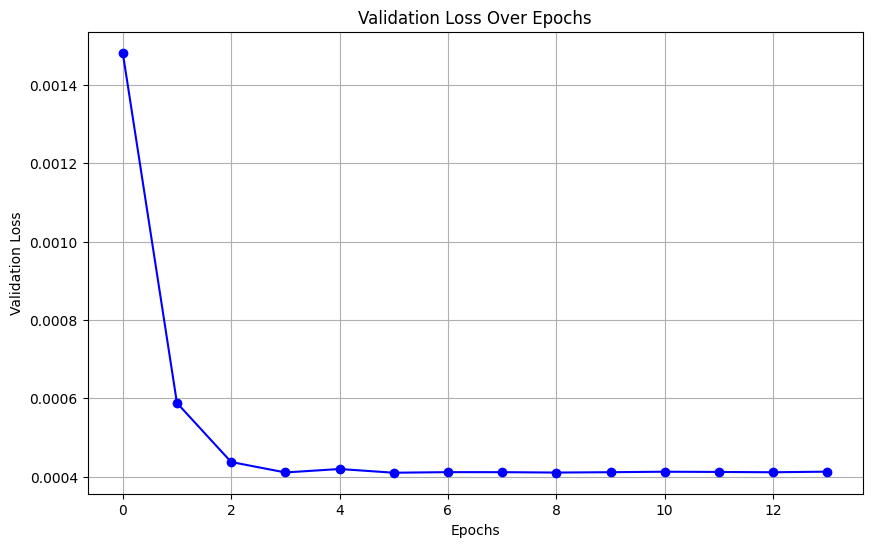

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(val_loss_rslts, marker='o', linestyle='-', color='b')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

#### 4.5. Evaluation des métriques de validation

In [46]:
def error_fn(df):
    """_summary_

    Args:
        df: DataFrame containing the data

    Returns:
        error: Error value
    """
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    """_summary_

    Args:
        female: DataFrame containing female data
        mage: DataFrame containing male data
    Returns:
        error: Computed total error which gives an idea of the average of the errors (model's performance for both groups) and the absolute difference between the errors (model's fairness)
    """
    err_male = error_fn(male)
    err_female = error_fn(female)
    print("Errors Male : ",err_male)
    print("Errors Female : ",err_female)
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [47]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

100%|██████████| 5001/5001 [05:36<00:00, 14.88it/s]


In [48]:
results_df.head()

pred  target  gender
0  0.005407   0.019   0.999
1  0.037265   0.035   1.000
2  0.132787   0.127   0.001
3  0.012716   0.014   0.999
4  0.349831   0.346   0.982

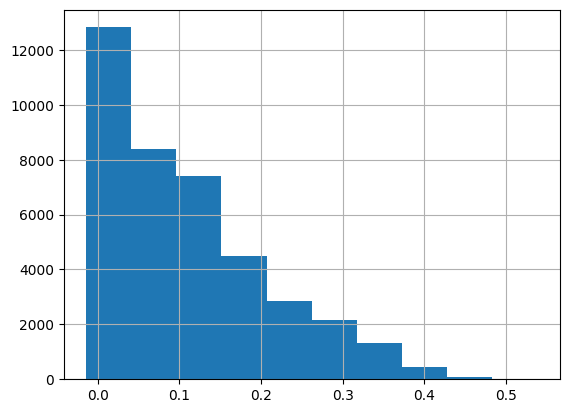

In [49]:
results_df['pred'].hist()
results_df['pred'] = results_df['pred'].apply(lambda x: 0 if x < 0 else x)

In [50]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]

In [51]:
print(metric_fn(results_male, results_female))
# print(error_fn(results_male), error_fn(results_female))

Errors Male :  0.0007875844695446013
Errors Female :  0.000694933439913551
0.0008339099843601264


In [52]:
print(len(results_male))
print(len(results_female))

14552
25450


### 5. Evaluation du dataset test

In [53]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [54]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [55]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [40:41<00:00,  1.56it/s]  


In [56]:
test_df = test_df.clip(lower=0)

In [57]:
test_df.head()

pred
0  0.276591
1  0.419481
2  0.361253
3  0.322824
4  0.431207

#### 6. Preparing your file for Submission

In [59]:
test_df.to_csv("Data_Challenge_15ep_equipercent_efficientnetb7_sansnegatif_mirror_earlystopping_vae.csv", header = None, index = None)